In [1]:
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import sys, os
import django
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from scipy.sparse import find

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import pickle
import scipy.sparse
import datetime
import scipy.stats as st
import scoping.utils.learning_utils as lu
from scoping.models import *
from utils.text import *
import matplotlib
import re



In [2]:
df = pd.read_csv('../data/category_predictions.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'id', 'content', 'title', 'wosarticle__de',
       'wosarticle__wc', 'ar5', 'seen', 'relevant',
       '12 - Coastal and marine Ecosystems',
       ...
       '6 - Water availability - k_prediction',
       '6 - Water availability - k_prediction_binary',
       '6 - Temperature - mean_prediction', '6 - Temperature - std_prediction',
       '6 - Temperature - lower_pred', '6 - Temperature - upper_pred',
       '6 - Precipitation - mean_prediction',
       '6 - Precipitation - std_prediction', '6 - Precipitation - lower_pred',
       '6 - Precipitation - upper_pred'],
      dtype='object', length=318)

In [3]:
# Driver was coded only as an impact, its driver was uncoded
df.loc[df['id']==112762,"6 - 07 Aridity/dryness"] = 1
df.loc[df['id']==112762,"6 - 72 Conflict"] = 0
df.loc[df['id']==112762,"4 - 72 Conflict"] = 1
df.loc[df['id']==112762,"6 - 76 Human water use"] = 1

# Unspecific climate change driver not coded
df.loc[df['id']==746862,"6 - 13 Other (physical systems)"] = 1
df.loc[df['id']==746862,"4 - 72 Conflict"] = 1
df.loc[df['id']==746862,"4 - 73 Displacement and migration"] = 1

# Driver and impact wrong way round
df.loc[df['id']==2342058,"4 - 72 Conflict"] = 1
df.loc[df['id']==2342058,"6 - 07 Aridity/dryness"] = 1

# Crop yield miscoded as driver
df.loc[df['id']==377564,"4 - 69 Crop yields"] = 1
df.loc[df['id']==377564,"6 - 69 Crop yields"] = 0

# Phenology not also recognised as intermediary impact
df.loc[df['id']==2504903,"4 - 52 Shifts in phenology (Terrestrial and freshwater)"] = 1

#
df.loc[df['id']==325492,"6 - 36 Species distribution (marine & coastal)"] = 1

#
df.loc[df['id']==98654,'4 - 02 Air or land surface temperature changes'] = 0
df.loc[df['id']==98654,'4 - 05 Changes in precipitation'] = 0

#
df.loc[df['id']==561026,'4 - 02 Air or land surface temperature changes'] = 0
df.loc[df['id']==561026,'6 - 02 Air or land surface temperature changes'] = 1
df.loc[df['id']==561026,'4 - 66 Health'] = 1
#df.loc[df['id']==,] =


#
df.loc[df['id']==2146364,'6 - 77 Land use change'] = 0
df.loc[df['id']==2146364,'6 - 58 Pests and diseases'] = 0
df.loc[df['id']==2146364,'6 - 51 Distribution and range shifts (Terrestrial and freshwater)'] = 0

#
df.loc[df['id']==1300494,'6 - 02 Air or land surface temperature changes'] = 1


#
df.loc[df['id']==1486581,'6 - 51 Distribution and range shifts (Terrestrial and freshwater)'] = 0
df.loc[df['id']==1486581,'4 - 51 Distribution and range shifts (Terrestrial and freshwater)'] = 1
df.loc[df['id']==1486581,'6 - 28 River runoff'] = 0


#
df.loc[df['id']==75669,'6 - 02 Air or land surface temperature changes'] = 1
df.loc[df['id']==75669,'6 - 05 Changes in precipitation'] = 1
df.loc[df['id']==75669,'6 - 25 Evapotranspiration'] = 1


In [4]:
df['2 - Trend or climate change attribtion'] = 0
 
df.loc[(df['2 - 2.2 Trend attribution']==1) | (df['2 - 2.1. Climate change attribution']==1),'2 - Trend or climate change attribtion'] = 1


seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index

qs = Query.objects.filter(pk__in=[8145,7368,8272])

physical_tags = Tag.objects.filter(query__in=qs,id__gt=5177)
pdos = DocOwnership.objects.filter(tag__in=physical_tags,relevant__gt=0).values_list('doc__id',flat=True)
physical_index = df[(df['id'].isin(list(pdos))) & (df['relevant']==1)].index
len(physical_index)

df['ca_rated'] = 0
df.loc[physical_index,'ca_rated'] = 1

attr_index = df[df['2 - Trend or climate change attribtion']==1].index

print(len(attr_index))

df.head()

458


,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,2 - 2.4. Sensitivity - std_prediction,2 - 2.4. Sensitivity - lower_pred,2 - 2.4. Sensitivity - upper_pred,2 - 2.5. Detection of a regional climate trend (no attribution) - mean_prediction,2 - 2.5. Detection of a regional climate trend (no attribution) - std_prediction,2 - 2.5. Detection of a regional climate trend (no attribution) - lower_pred,2 - 2.5. Detection of a regional climate trend (no attribution) - upper_pred,PY,6 - 13 Other (physical systems),ca_rated
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,0.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,2014.0,NaN,0
1,1,1284614,Tree-ring width chronologies from the upper ti...,Separating temperature from precipitation sign...,Northeastern Tibetan Plateau; Tree-ring width;...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,0.372678,0.460655,1.000000,0.0,0.0,0.0,0.0,2018.0,NaN,0
2,2,1344242,This study examines the spatial and temporal p...,GIS analysis of spatial and temporal patterns ...,fire; geographic information systems; manageme...,['Forestry'],0.0,0.0,0.0,0.0,...,0.372678,0.000000,0.539345,0.0,0.0,0.0,0.0,2001.0,NaN,0
3,3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",Permafrost; Thermokarst lakes; Hydrological cy...,"['Engineering, Civil; Geosciences, Multidiscip...",0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2012.0,NaN,0
4,4,399966,"Since 2005, Morocco has designated 28 Importan...",Factors Influencing Species-Richness of Breedi...,Breeding waterfowl; Diversity; Spatial scale; ...,['Ecology; Environmental Sciences'],0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2015.0,NaN,0


,driver,n,intermediate_driver,primary_driver
0,6 - 01 CO2 concentration,24.0,0.0,24.0
1,6 - 02 Air or land surface temperature changes,425.0,8.0,417.0
2,6 - 03 Extreme temperature,111.0,0.0,111.0
3,6 - 04 Radiation,10.0,0.0,10.0
4,6 - 05 Changes in precipitation,258.0,9.0,249.0


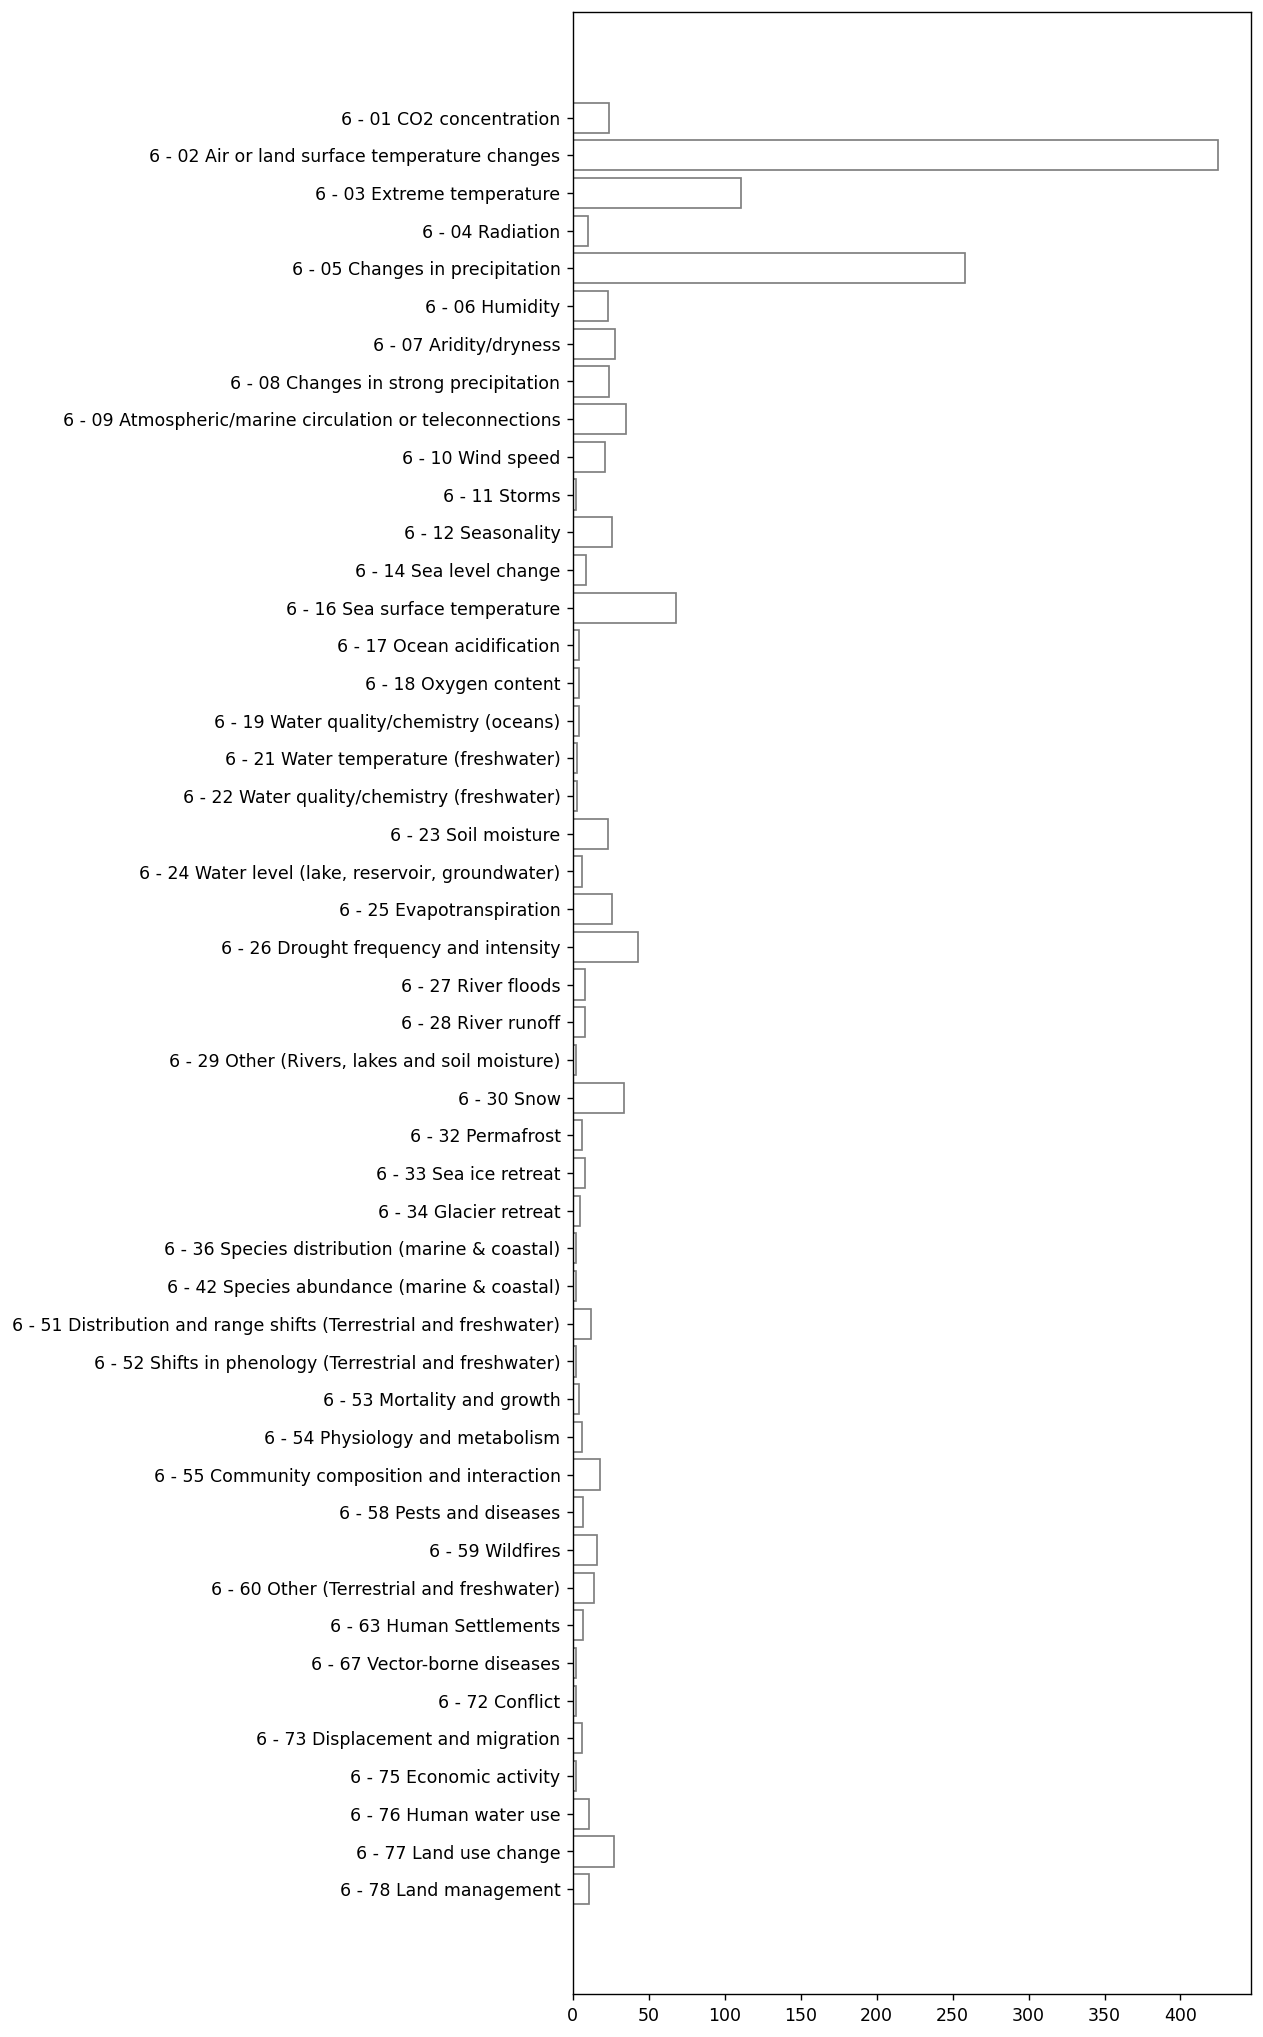

In [5]:
drivers = []
driver_dict = []
fig, ax = plt.subplots(dpi=125, figsize=(7,21))
i = 0
for c in df.columns:
    if "prediction" in c:
        continue
    if re.match("^6 - " ,c):
        im = c.replace("6 - ","4 - ")
        n = df[c].sum()
        if im not in df.columns:
            di = 0
            p_d = n
        else:
            di = df.loc[df[im]==1,c].sum()
            p_d = df.loc[df[im]==0,c].sum()
        if n < 2:
            continue
        driver_dict.append({"driver": c, "n":n, "intermediate_driver": di, "primary_driver":p_d})
        ax.barh(i,n,color="None",edgecolor="grey")
        i+=1
        
plt.gca().invert_yaxis()

driver_df = pd.DataFrame.from_dict(driver_dict)

ax.set_yticks(driver_df.index)
ax.set_yticklabels(driver_df['driver'])

all_drivers = list(driver_df['driver'])

driver_df.head()

In [6]:
df['6 - No drivers'] = 0
df.loc[(df['ca_rated']==1) & (df.loc[:,all_drivers].sum(axis=1)==0),"6 - No drivers"] = 1

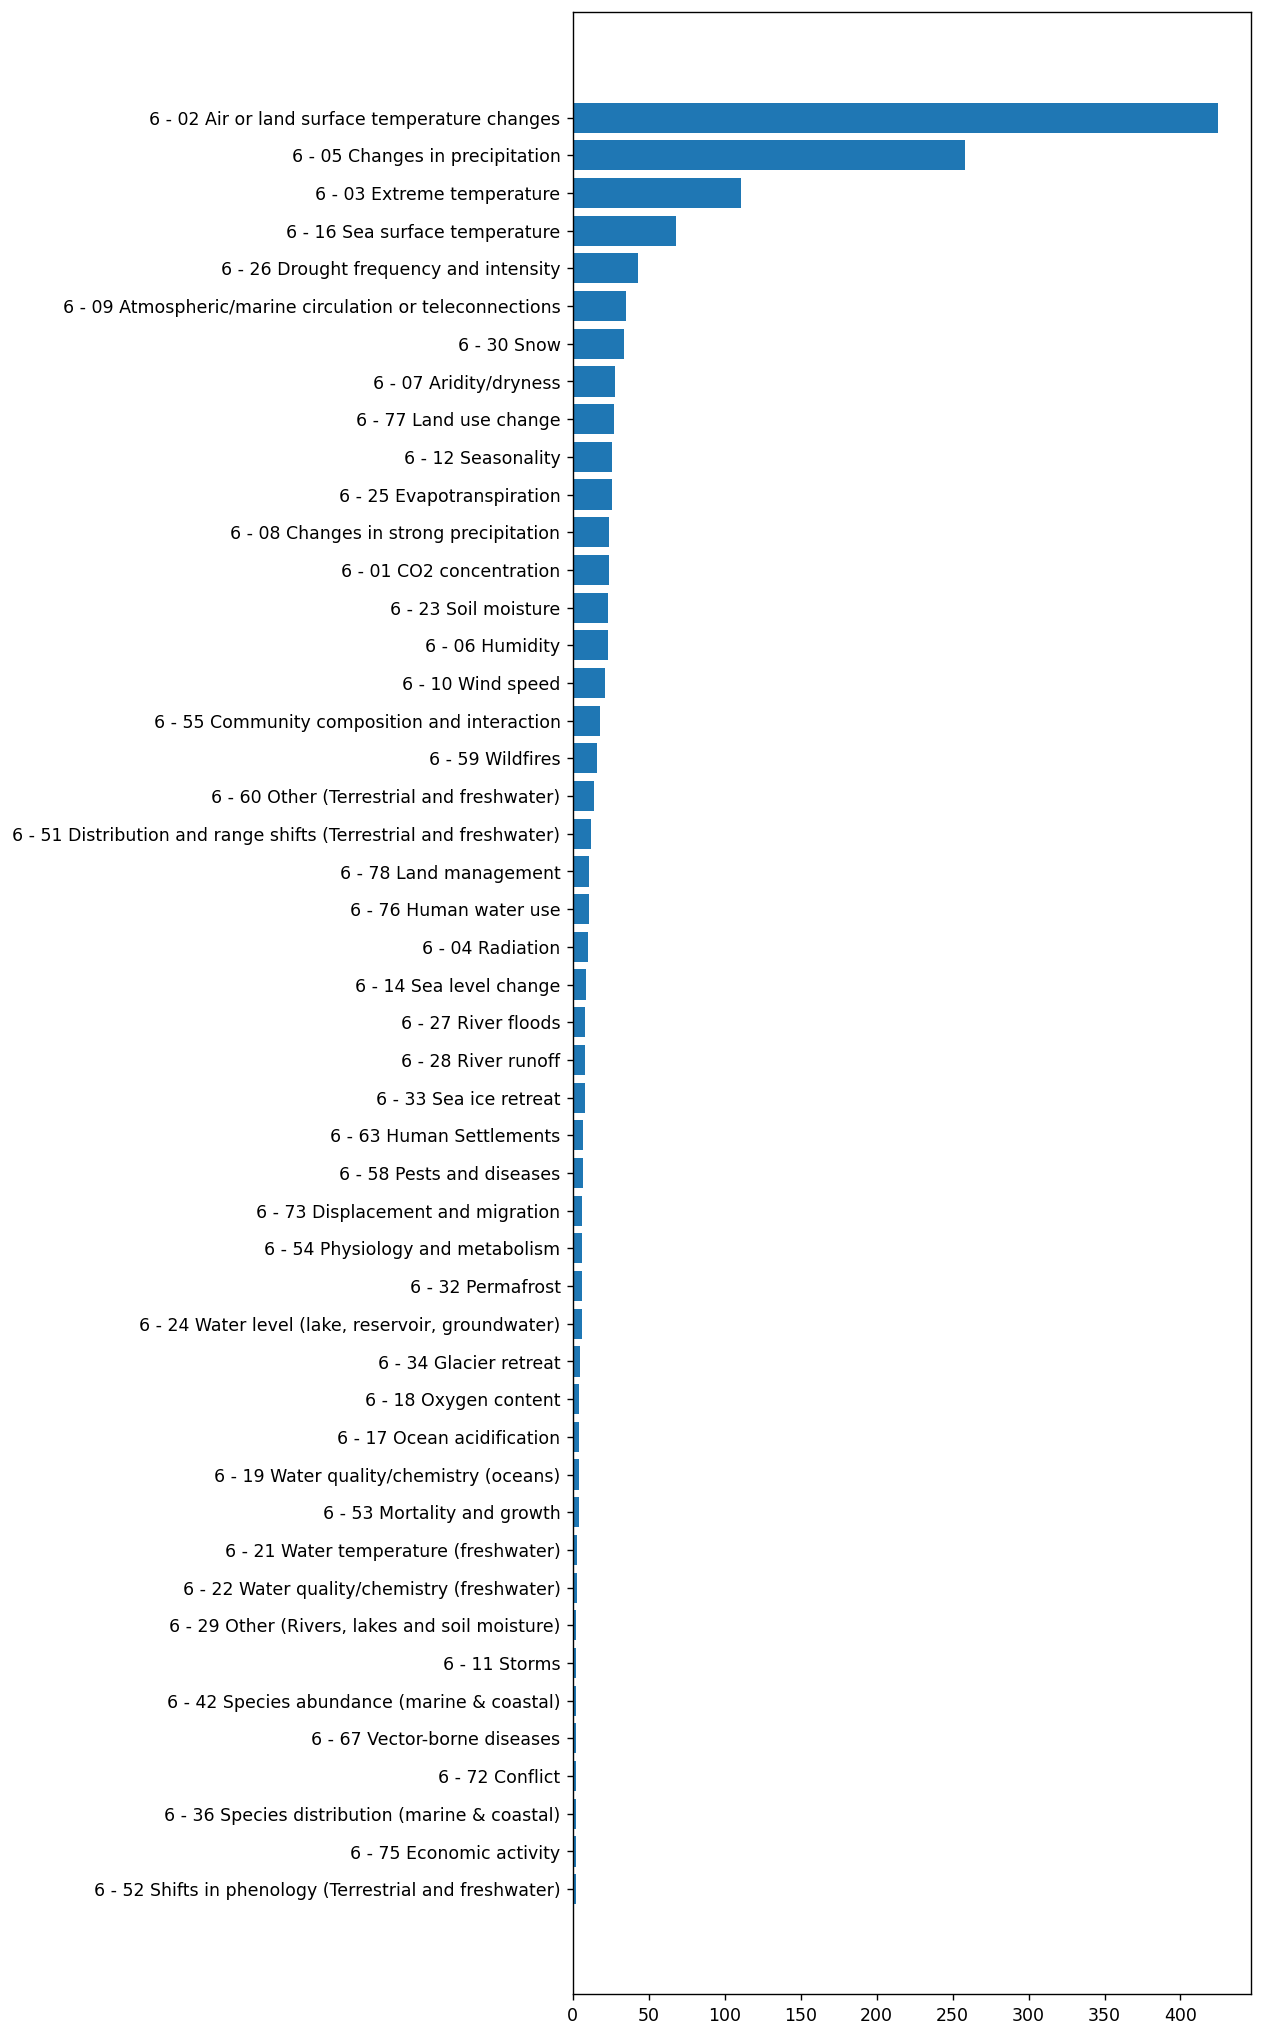

In [7]:
fig, ax = plt.subplots(dpi=125, figsize=(7,21))

pdf = driver_df.sort_values('n').reset_index(drop=True)
ax.barh(pdf.index, pdf['n'])


ax.set_yticks(pdf.index)
ax.set_yticklabels(pdf['driver'])

plt.show()

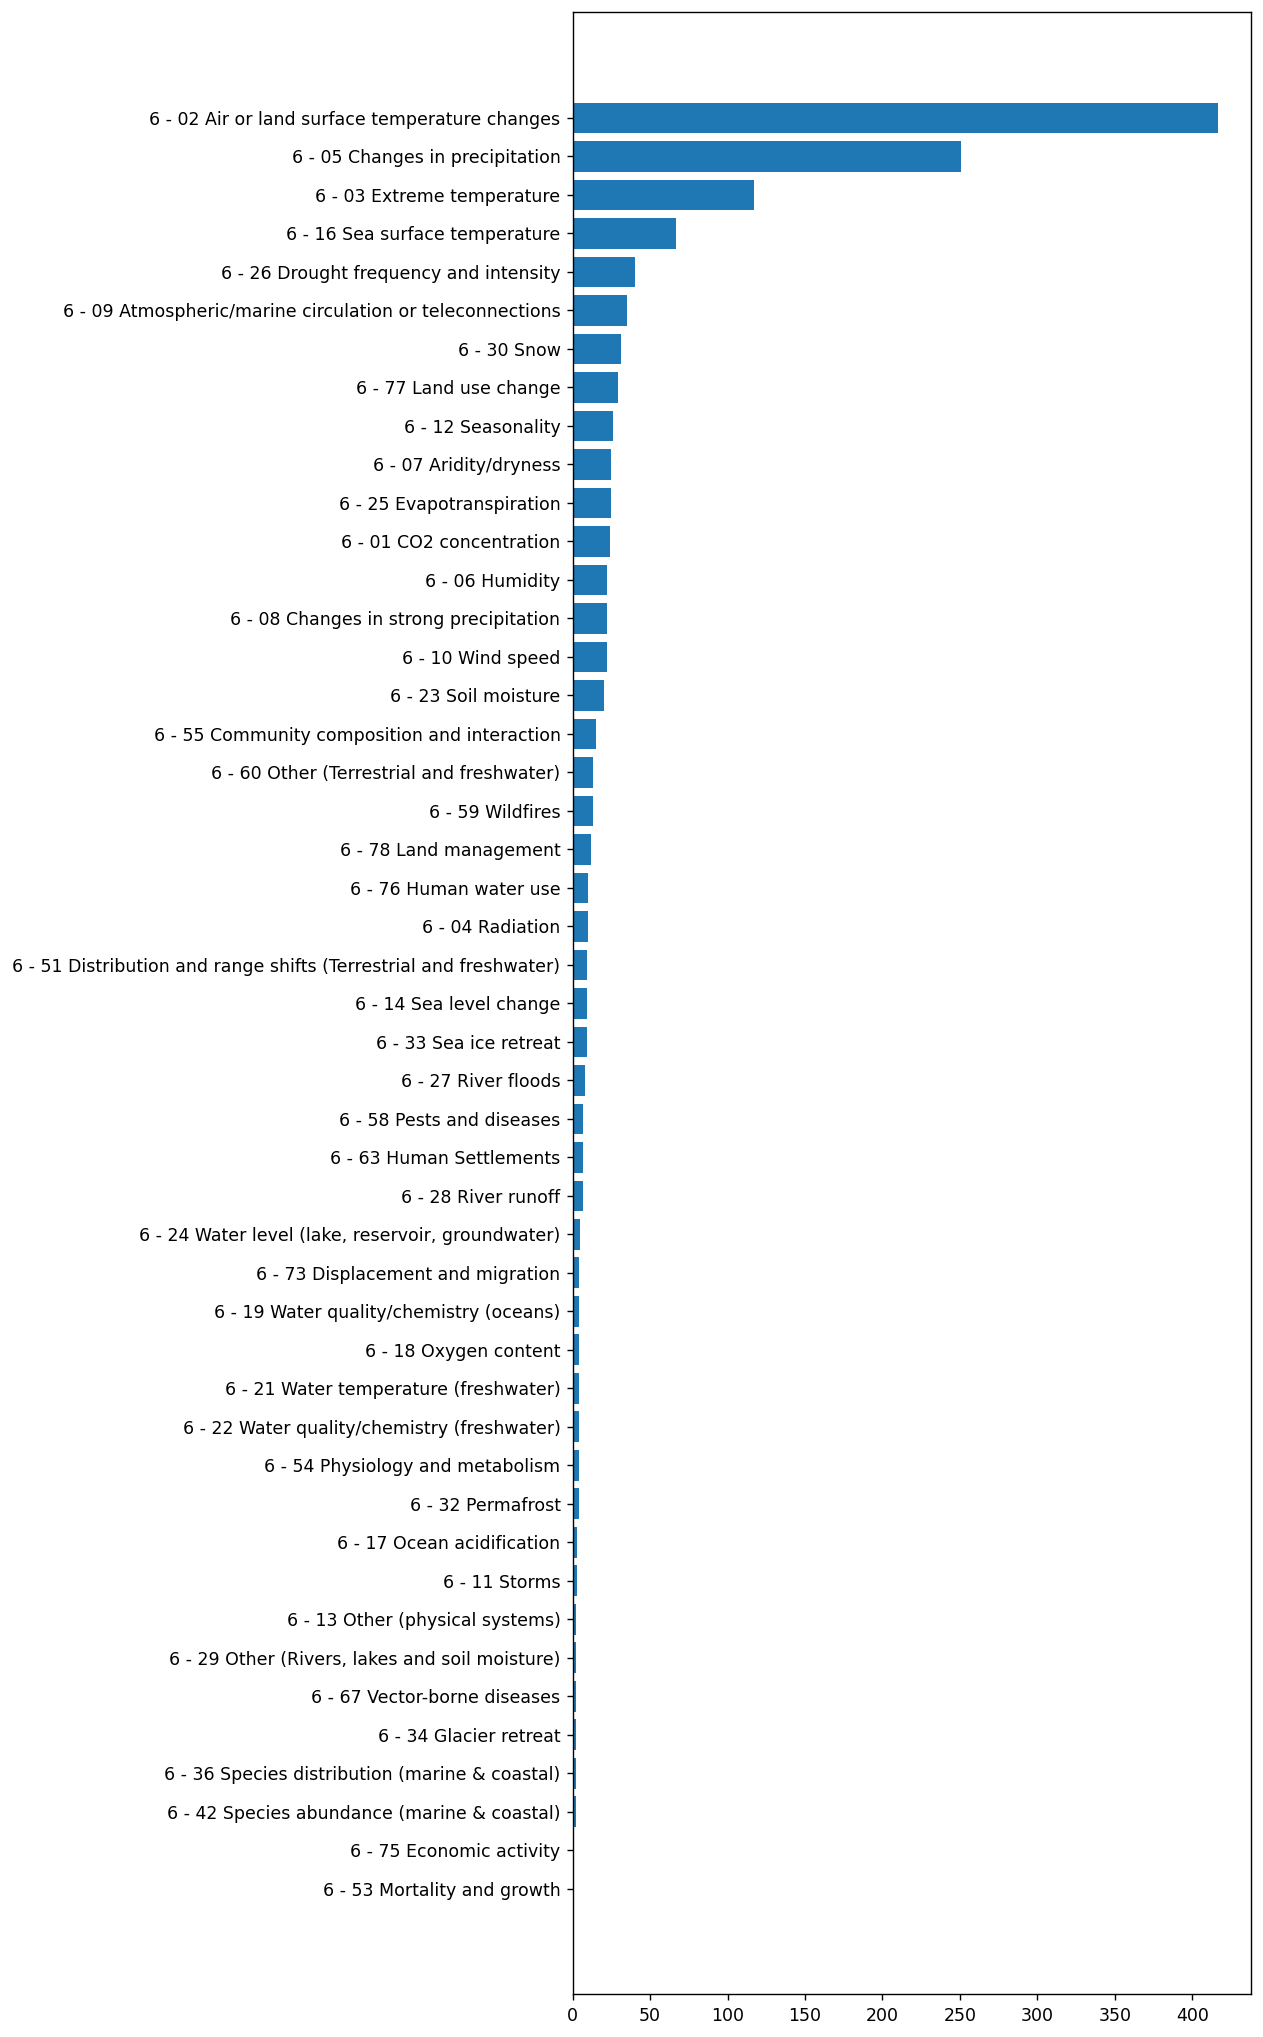

In [8]:
fig, ax = plt.subplots(dpi=125, figsize=(7,21))

pdf = driver_df.query('primary_driver>0').sort_values('primary_driver').reset_index(drop=True)
ax.barh(pdf.index, pdf['primary_driver'])


ax.set_yticks(pdf.index)
ax.set_yticklabels(pdf['driver'])

plt.show()

In [9]:
driver_df.head(15)

,driver,n,intermediate_driver,primary_driver
0,6 - 01 CO2 concentration,24.0,0.0,24.0
1,6 - 02 Air or land surface temperature changes,425.0,8.0,417.0
2,6 - 03 Extreme temperature,117.0,0.0,117.0
3,6 - 04 Radiation,10.0,0.0,10.0
4,6 - 05 Changes in precipitation,260.0,9.0,251.0
5,6 - 06 Humidity,23.0,1.0,22.0
6,6 - 07 Aridity/dryness,28.0,3.0,25.0
7,6 - 08 Changes in strong precipitation,25.0,3.0,22.0
8,6 - 09 Atmospheric/marine circulation or telec...,38.0,3.0,35.0
9,6 - 10 Wind speed,22.0,0.0,22.0


In [10]:
## New summary cats
df['6 - Precipitation'] = 0
df.loc[(df['6 - 05 Changes in precipitation']==1) | (df['6 - 08 Changes in strong precipitation']==1),"6 - Precipitation"] = 1

df['Human drivers'] = 0
df.loc[
    (df['6 - 76 Human water use']==1) |
    (df['6 - 77 Land use change']==1),
    '6 - Human drivers' 
] = 1
 
df.loc[
    (df['6 - 03 Extreme temperature']==1) & 
    (df['6 - 16 Sea surface temperature']==0) & 
    (df['6 - 21 Water temperature (freshwater)']==0),
    '6 - 02 Air or land surface temperature changes'
] = 1

df['6 - Temperature'] = 0
df.loc[
    (df['6 - 03 Extreme temperature']==1) | 
    (df['6 - 16 Sea surface temperature']==1) | 
    (df['6 - 02 Air or land surface temperature changes']==1) |
    (df['6 - 21 Water temperature (freshwater)']==1),
    '6 - Temperature'
] = 1

df['6 - Water availability'] = 0
df.loc[
    (df['6 - 26 Drought frequency and intensity']==1) |
    (df['6 - 07 Aridity/dryness']==1) |
    (df['6 - 28 River runoff']==1),
    '6 - Water availability'
] = 1

driver_selection = [
    #'6 - 01 CO2 concentration',
    '6 - 02 Air or land surface temperature changes','6 - Precipitation','6 - 16 Sea surface temperature',
    '6 - 09 Atmospheric/marine circulation or teleconnections',
    #'6 - 10 Wind speed','6 - 11 Storms','6 - 14 Sea level change',#'6 - 26 Drought frequency and intensity',
    #'6 - 04 Radiation',
    #'6 - 33 Sea ice retreat',
    '6 - No drivers', '6 - 30 Snow', '6 - Human drivers', 
    #'6 - 12 Seasonality',
    '6 - Water availability',
]

all_docs = df[df['ca_rated']==True].reset_index(drop=True)
print(all_docs.shape[0])

covered = all_docs[all_docs[driver_selection].sum(axis=1)>0]
uncovered = all_docs[all_docs[driver_selection].sum(axis=1)==0]

print(f"{covered.shape[0]/all_docs.shape[0]:.1%}")

831
94.6%


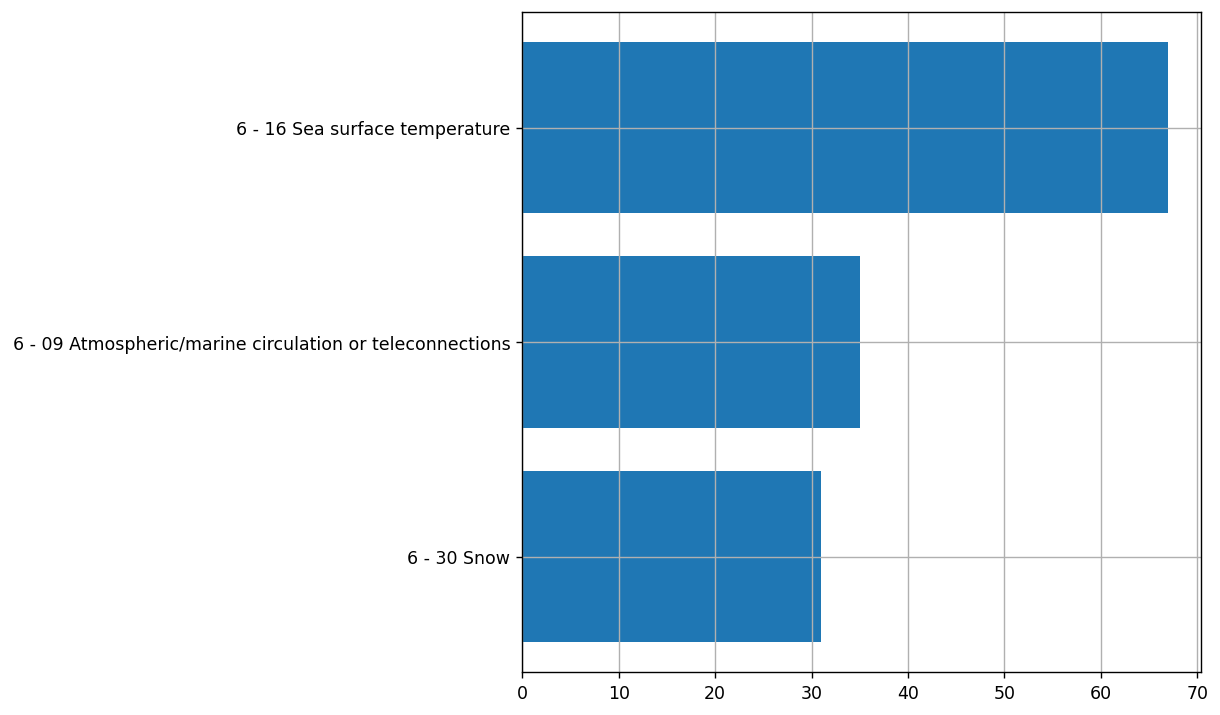

In [11]:
fig, ax = plt.subplots(dpi=125, figsize=(7,7))

pdf = driver_df.loc[driver_df['driver'].isin(driver_selection),].query('n<100').sort_values('primary_driver').reset_index(drop=True)
ax.barh(pdf.index, pdf['primary_driver'])


ax.set_yticks(pdf.index)
ax.set_yticklabels(pdf['driver'])

ax.grid()

plt.show()


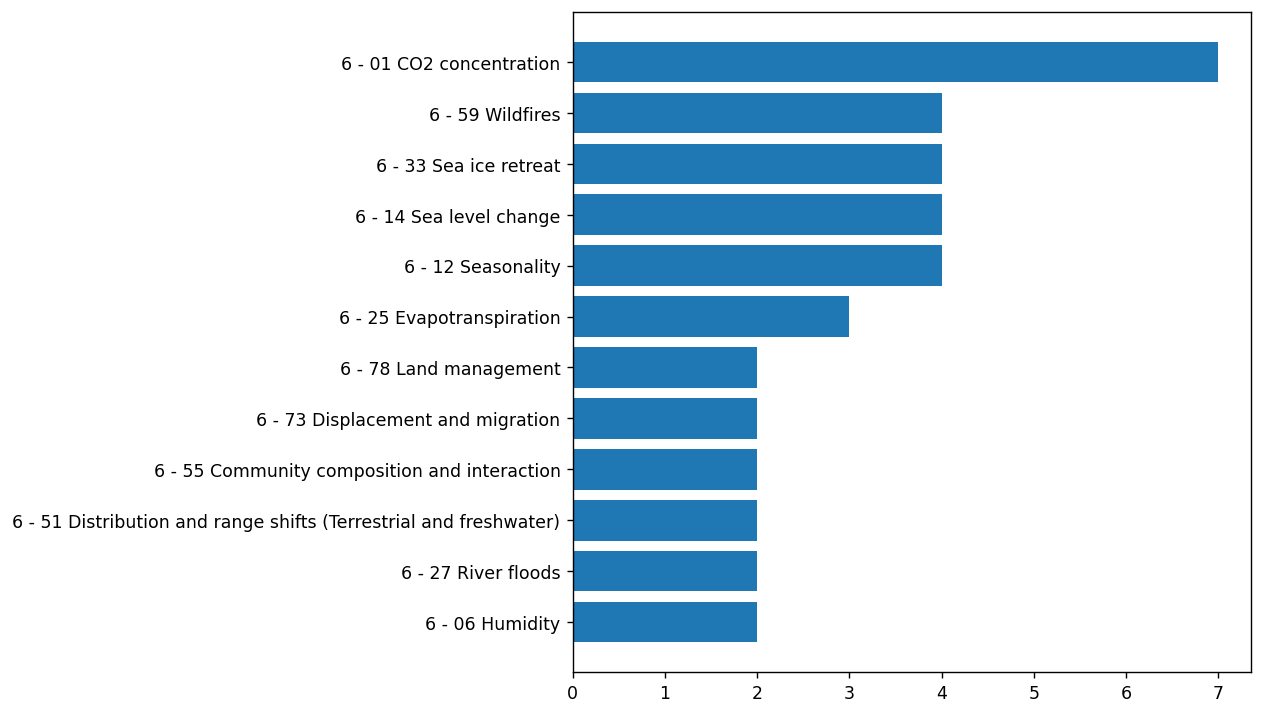

In [12]:
driver_dict = []

for c in df.columns:
    if "prediction" in c or c in driver_selection:
        continue
    if re.match("^6 - " ,c):
        im = c.replace("6 - ","4 - ")
        n = uncovered[c].sum()
        if im not in df.columns:
            di = 0
            p_d = n
        else:
            di = uncovered.loc[uncovered[im]==1,c].sum()
            p_d = uncovered.loc[uncovered[im]==0,c].sum()
        if n < 2:
            continue
        driver_dict.append({"driver": c, "n":n, "intermediate_driver": di, "primary_driver":p_d})
        #ax.barh(i,n,color="None",edgecolor="grey")
        i+=1
        
fig, ax = plt.subplots(dpi=125, figsize=(7,7))

pdf = pd.DataFrame.from_dict(driver_dict).sort_values('n').reset_index(drop=True)
ax.barh(pdf.index, pdf['n'])


ax.set_yticks(pdf.index)
ax.set_yticklabels(pdf['driver'])

plt.show()

In [13]:
df.loc[df['id']==112762,"6 - 07 Aridity/dryness"]

41459    1.0
Name: 6 - 07 Aridity/dryness, dtype: float64

In [14]:
django.db.connection.close()
sub_df = df.loc[(df['6 - 51 Distribution and range shifts (Terrestrial and freshwater)']==1)]
print(sub_df.shape[0])
for i, row in sub_df.iterrows():
    print("\n",row['title'])
    print(row['content'])
    d = Doc.objects.get(pk=row['id'])
    print(d.id)
    print("impacts:")
    print(d.docusercat_set.filter(category__level=4).values('category__name','user__username'))
    print("drivers:")
    print(d.docusercat_set.filter(category__level=6).values('category__name','user__username'))

14

 Spatiotemporal Analysis of Actual Evapotranspiration and Its Causes in the Hai Basin
Evapotranspiration (ET) is an important component of the eco-hydrological process. Comprehensive analyses of ET change at different spatial and temporal scales can enhance the understanding of hydrological processes and improve water resource management. In this study, monthly ET data and meteorological data from 57 meteorological stations between 2000 and 2014 were used to study the spatiotemporal changes in actual ET and the associated causes in the Hai Basin. A spatial analysis was performed in GIS to explore the spatial pattern of ET in the basin, while parametric t-test and nonparametric Mann-Kendall test methods were used to analyze the temporal characteristics of interannual and annual ET. The primary causes of the spatiotemporal variations were partly explained by detrended fluctuation analysis. The results were as follows: (i) generally, ET increased from northwest to southeast across the

In [8]:
qid = 8272
revectorize = True
retransform = False
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2, max_df=0.8, strip_accents='unicode', 
        max_features=10000,
        tokenizer=snowball_stemmer(),
        sublinear_tf=True
    )
    vec.fit(df.loc[physical_index,'content'].astype("str") + " " + df.loc[physical_index,'title'] + df.loc[physical_index,"wosarticle__de"])

    X = vec.transform(df['content'].astype("str")+" " + df['title'].astype("str") + df['wosarticle__de'].astype("str"))    
    with open (f'../data/vec_{qid}_prel.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{qid}_prel.npz', X)
else:
    with open (f'../data/vec_{qid}_prel.pickle','rb') as f:
        vec = pickle.load(f)
        if retransform:
            X = vec.transform(df['content'].astype("str"))
            scipy.sparse.save_npz(f'../data/X_{qid}_prel.npz', X)
        else:
            X = scipy.sparse.load_npz(f'../data/X_{qid}_prel.npz')
            
            
print(df.shape)
print(X.shape)

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(84825, 294)
(84825, 10000)


In [16]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

import scoping.utils

from importlib import reload  
reload(scoping.utils.learning_utils)


classes = driver_selection
y = np.matrix(df[classes].fillna(0))
print(y.shape)

multimodels = [
    #{
    #    'title': 'One vs rest SVC', 
    #    'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    #},
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_drivers, metrics, df = lu.cross_validate_models(X, y, multimodels, physical_index, n_splits=6, classes=classes, df = df)

(84832, 8)
1
2


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


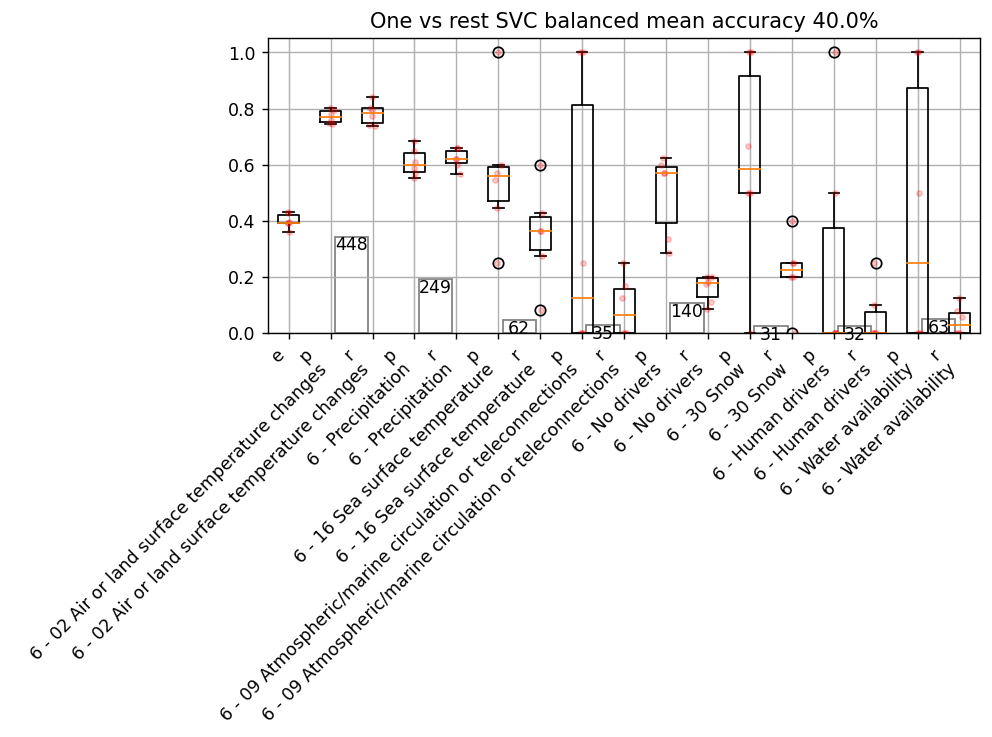

In [17]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(multimodels_drivers, metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

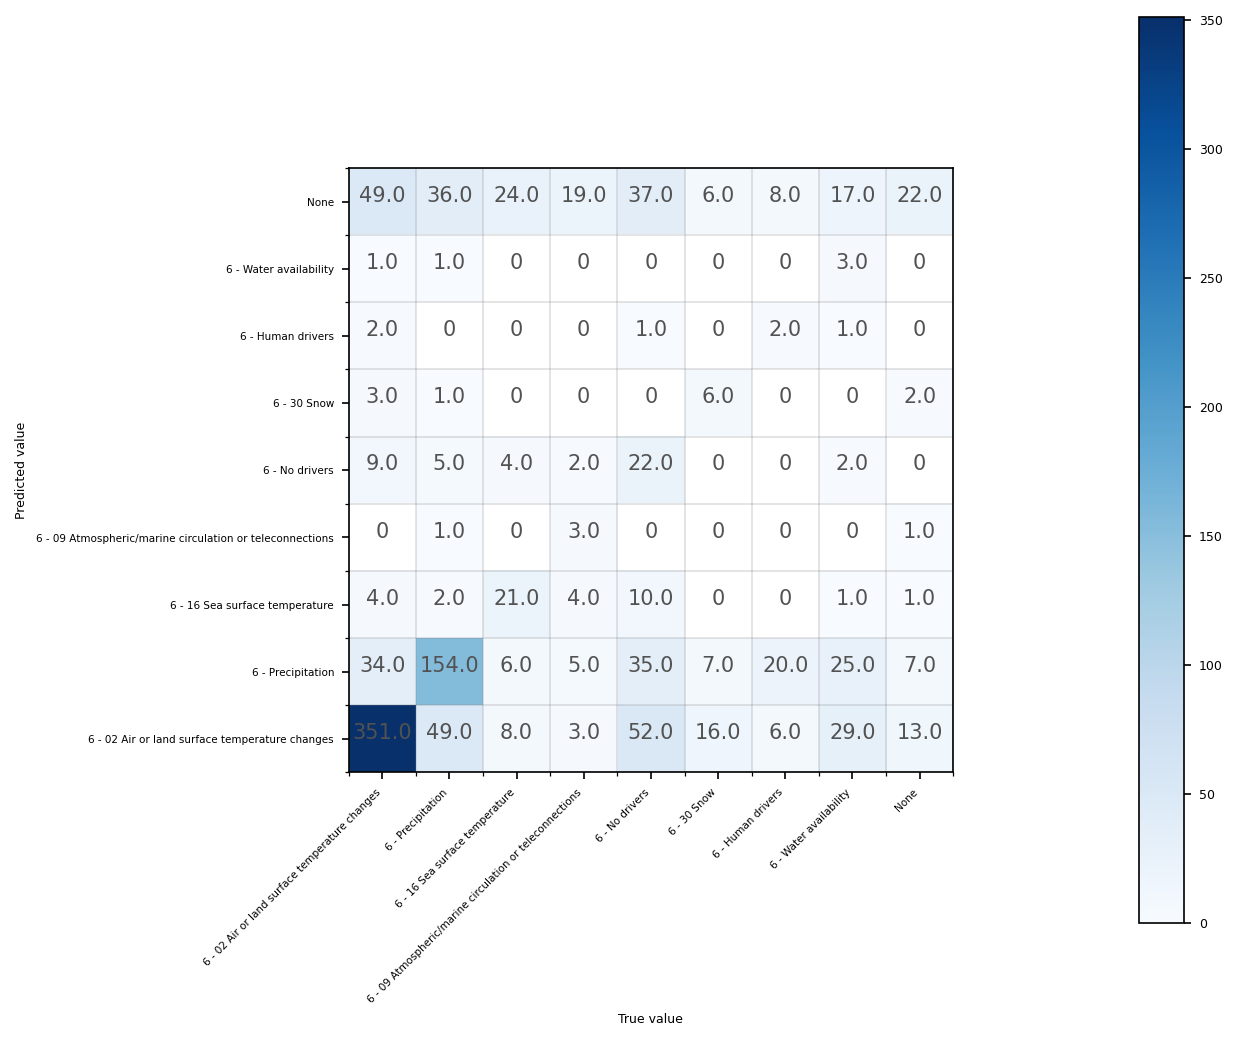

In [18]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)
classes = driver_selection

cols = [f"{c} - k_prediction_binary" for c in classes]

y_pred = np.zeros((y[physical_index].shape[0],y[physical_index].shape[1]+1))
y_pred[:,:-1] = np.array(list(df.loc[list(physical_index),cols].values))
y_pred[:,len(classes)] = np.where(y_pred.sum(axis=1)==0,1,0)
   
y_true = np.zeros((y[physical_index].shape[0],y[physical_index].shape[1]+1))
y_true[:,:-1] = y[physical_index]
y_true[:,len(classes)] = np.where(y_true.sum(axis=1)==0,1,0)


confusion_matrix = np.zeros(shape=(len(cols)+1,len(cols)+1),dtype=float)

classes = classes+["None"]

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(physical_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n
        
    #sums_pred = y_pred.sum(axis=1).ravel()
    #confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    #sums_true = y_true.sum(axis=1).ravel()
    #confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    #confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]


def plot_confusion_matrix(cm, all_classes, norm=None, broad_cats = [], ls=False):
    cm = np.copy(cm)
    if norm is not None:
        cm = cm/cm.sum(axis=norm,keepdims=True)
    cm[cm == 0] = np.nan

    mat = ax.imshow(cm, cmap="Blues",vmin=0,origin="lower")
    ax.set_xticks(np.arange(-.5, cm.shape[0], 1), minor=True);
    ax.set_yticks(np.arange(-.5, cm.shape[0], 1), minor=True);

    ax.grid(which="minor",color='grey', linestyle='-', linewidth=0.2)

    if ls:
        for j, c in enumerate(all_classes):
            for k, c in enumerate(all_classes):
                n  = cm[k,j]
                if pd.isna(n):
                    n = 0
                if n > cm.max()/2:
                    color="#d9d9d9"
                else:
                    color="#525252"
                if norm is not None:
                    ax.text(j,k, f"{n:.0%}",ha="center",color=color)
                else:
                    ax.text(j,k, f"{n}",ha="center",color=color)
                
            #if j < len(all_classes)+21:    
            #    ax.text(j,len(all_classes)-0.25,f"{y_true[:,j].sum():,.0f}",ha="center",va="center",color="#525252")
            #    ax.text(len(all_classes)-0.25, j, f"{y_pred[:,j].sum():,.0f}",ha="center",va="center", color="#525252")

    ax.set_xticks(list(range(len(all_classes))))
    ax.set_xticklabels([x.replace("4 - ","") for x in all_classes],rotation=45,ha="right",fontsize=5)

    ax.set_yticks(list(range(len(all_classes))))
    ax.set_yticklabels([x.replace("4 - ","") for x in all_classes],ha="right",fontsize=5)
    ax.set_xlabel("True value", fontsize=6)
    ax.set_ylabel("Predicted value", fontsize=6)


    cbar = fig.colorbar(mat, ax=ax, pad=0.2)
    cbar.ax.tick_params(labelsize=6)
    if norm ==0:
        cbar.set_label("% of True values")
    
    for bc in broad_cats:
        rect = patches.Rectangle((bc['start']-0.5,bc['start']-0.5),bc['size'],bc['size'],fill=False)
        ax.add_patch(rect)
    

plot_confusion_matrix(confusion_matrix, classes, norm=None, ls=True)   
#plot_confusion_matrix(confusion_matrix,classes, norm=1)

In [19]:
## New summary cats
df['6 - Precipitation'] = 0
df.loc[(df['6 - 05 Changes in precipitation']==1) | (df['6 - 08 Changes in strong precipitation']==1),"6 - Precipitation"] = 1

df['Human drivers'] = 0
df.loc[
    (df['6 - 76 Human water use']==1) |
    (df['6 - 77 Land use change']==1),
    '6 - Human drivers' 
] = 1
 
df.loc[
    (df['6 - 03 Extreme temperature']==1) & 
    (df['6 - 16 Sea surface temperature']==0) & 
    (df['6 - 21 Water temperature (freshwater)']==0),
    '6 - 02 Air or land surface temperature changes'
] = 1

df['6 - Temperature'] = 0
df.loc[
    (df['6 - 03 Extreme temperature']==1) | 
    (df['6 - 16 Sea surface temperature']==1) | 
    (df['6 - 02 Air or land surface temperature changes']==1) |
    (df['6 - 21 Water temperature (freshwater)']==1),
    '6 - Temperature'
] = 1

df['6 - Water availability'] = 0
df.loc[
    (df['6 - 26 Drought frequency and intensity']==1) |
    (df['6 - 07 Aridity/dryness']==1) |
    (df['6 - 28 River runoff']==1),
    '6 - Water availability'
] = 1

driver_selection = [
    #'6 - 01 CO2 concentration',
    '6 - Temperature',
    '6 - Precipitation',#'6 - 16 Sea surface temperature',
    #'6 - 09 Atmospheric/marine circulation or teleconnections',
    #'6 - 10 Wind speed','6 - 11 Storms','6 - 14 Sea level change',#'6 - 26 Drought frequency and intensity',
    #'6 - 04 Radiation',
    #'6 - 33 Sea ice retreat',
    #'6 - No drivers', '6 - 30 Snow', '6 - Human drivers', 
    #'6 - 12 Seasonality',
    #'6 - Water availability',
]

all_docs = df[df['ca_rated']==True].reset_index(drop=True)
print(all_docs.shape[0])

covered = all_docs[all_docs[driver_selection].sum(axis=1)>0]
uncovered = all_docs[all_docs[driver_selection].sum(axis=1)==0]

print(f"{covered.shape[0]/all_docs.shape[0]:.1%}")

831
70.0%


In [20]:
classes = driver_selection

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

import scoping.utils

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    #{
    #    'title': 'One vs rest SVC', 
    #    'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    #},
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_drivers_few, metrics, df = lu.cross_validate_models(X, y, multimodels, physical_index, n_splits=6, classes=classes, df = df)

(84832, 2)
1
2
3
4
5
6


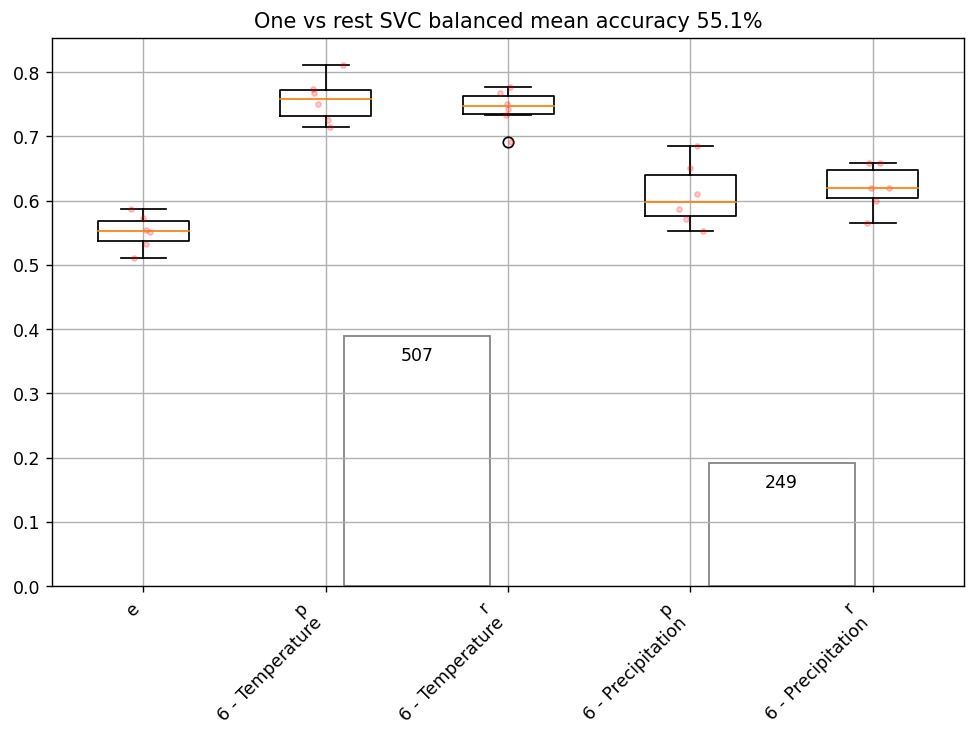

In [21]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(multimodels_drivers_few, metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

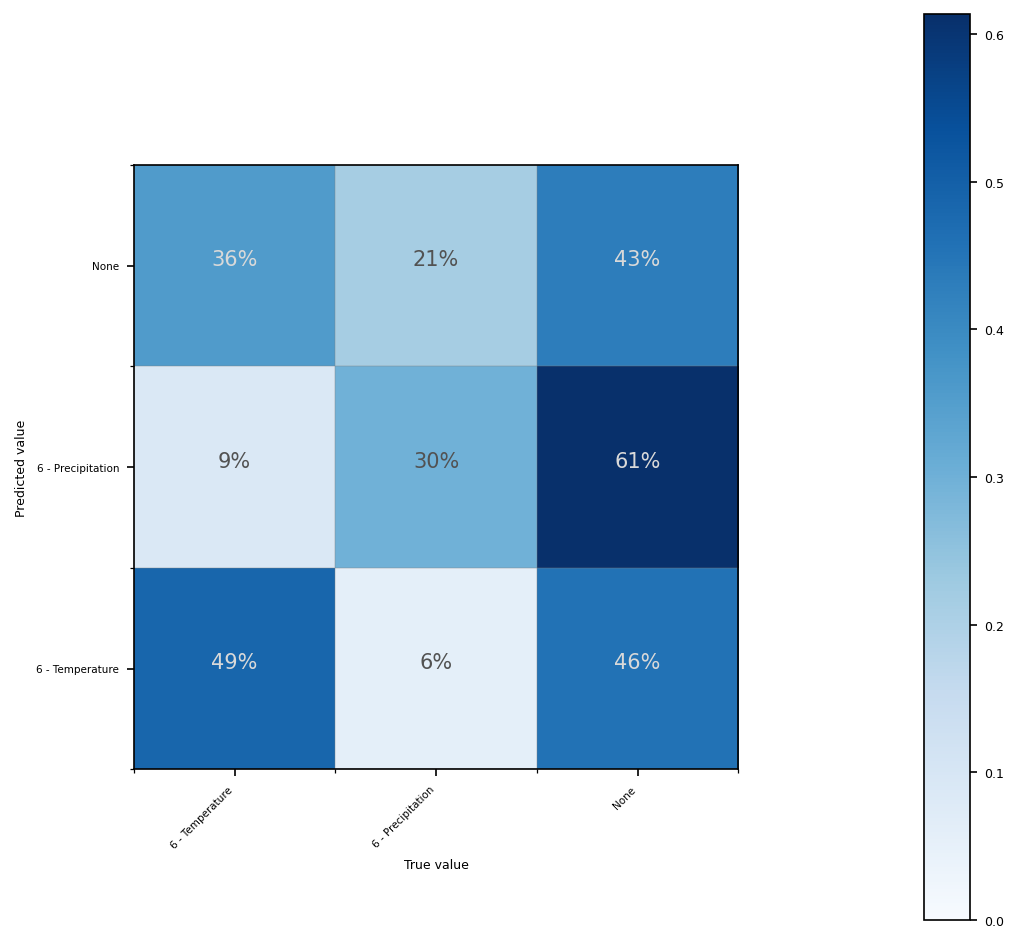

In [22]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)

classes = driver_selection

cols = [f"{c} - k_prediction_binary" for c in classes]
y_pred = np.array(list(df.loc[list(physical_index),cols].values))
   
y_true = y[physical_index]

confusion_matrix = np.zeros(shape=(len(cols)+1,len(cols)+1),dtype=float)

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(physical_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n
        
    sums_pred = y_pred.sum(axis=1).ravel()
    confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    sums_true = y_true.sum(axis=1).ravel()
    confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]

        
plot_confusion_matrix(confusion_matrix,classes + ["None"], norm=1, ls=True)

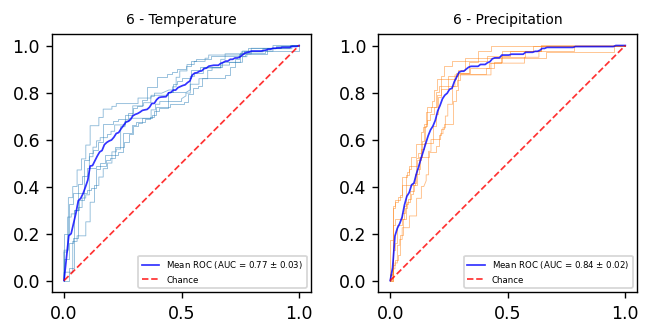

In [23]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for model in multimodels_drivers_few:
    for j,c in enumerate(classes):
        ax = fig.add_subplot(2,3,j+1)
        mean_fpr = np.linspace(0, 1, 100)
        mean_auc = np.mean(model[f'auc\n{c}'])
        std_auc = np.std(model[f'auc\n{c}'])
        tprs = []
        for i in range(len(model['i'])):
            viz = ax.plot(
                model[f'fpr\n{c}'][i],
                model[f'tpr\n{c}'][i],
                lw=0.5,
                alpha=0.5,
                color=f"C{j}"
            )
            
            interp_tpr = interp(mean_fpr, model[f'fpr\n{c}'][i], model[f'tpr\n{c}'][i])
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=1, alpha=.8)
        ax.set_title(c,fontsize=8)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
            label='Chance', alpha=.8)

        ax.legend(fontsize=5)
        ax.set_aspect("equal")
            
fig.tight_layout()

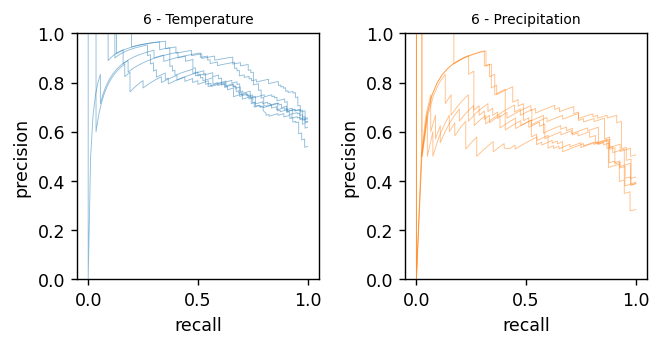

In [24]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for model in multimodels_drivers_few:
    for j,c in enumerate(classes):
        ax = fig.add_subplot(2,3,j+1)
        mean_fpr = np.linspace(0, 1, 100)
        mean_auc = np.mean(model[f'auc\n{c}'])
        std_auc = np.std(model[f'auc\n{c}'])
        tprs = []
        for i in range(len(model['i'])):
            viz = ax.plot(
                model[f'rec\n{c}'][i],
                model[f'prec\n{c}'][i],
                lw=0.5,
                alpha=0.5,
                color=f"C{j}"
            )
        ax.set_ylabel('precision')
        ax.set_xlabel('recall')
        ax.set_title(c,fontsize=8)
        ax.set_ylim((0,1))
        
fig.tight_layout()

# Again with only those documents that have attribution

,driver,n,intermediate_driver,primary_driver
0,6 - 01 CO2 concentration,15.0,0.0,24.0
1,6 - 02 Air or land surface temperature changes,219.0,8.0,417.0
2,6 - 03 Extreme temperature,30.0,0.0,111.0
3,6 - 04 Radiation,8.0,0.0,10.0
4,6 - 05 Changes in precipitation,141.0,9.0,249.0


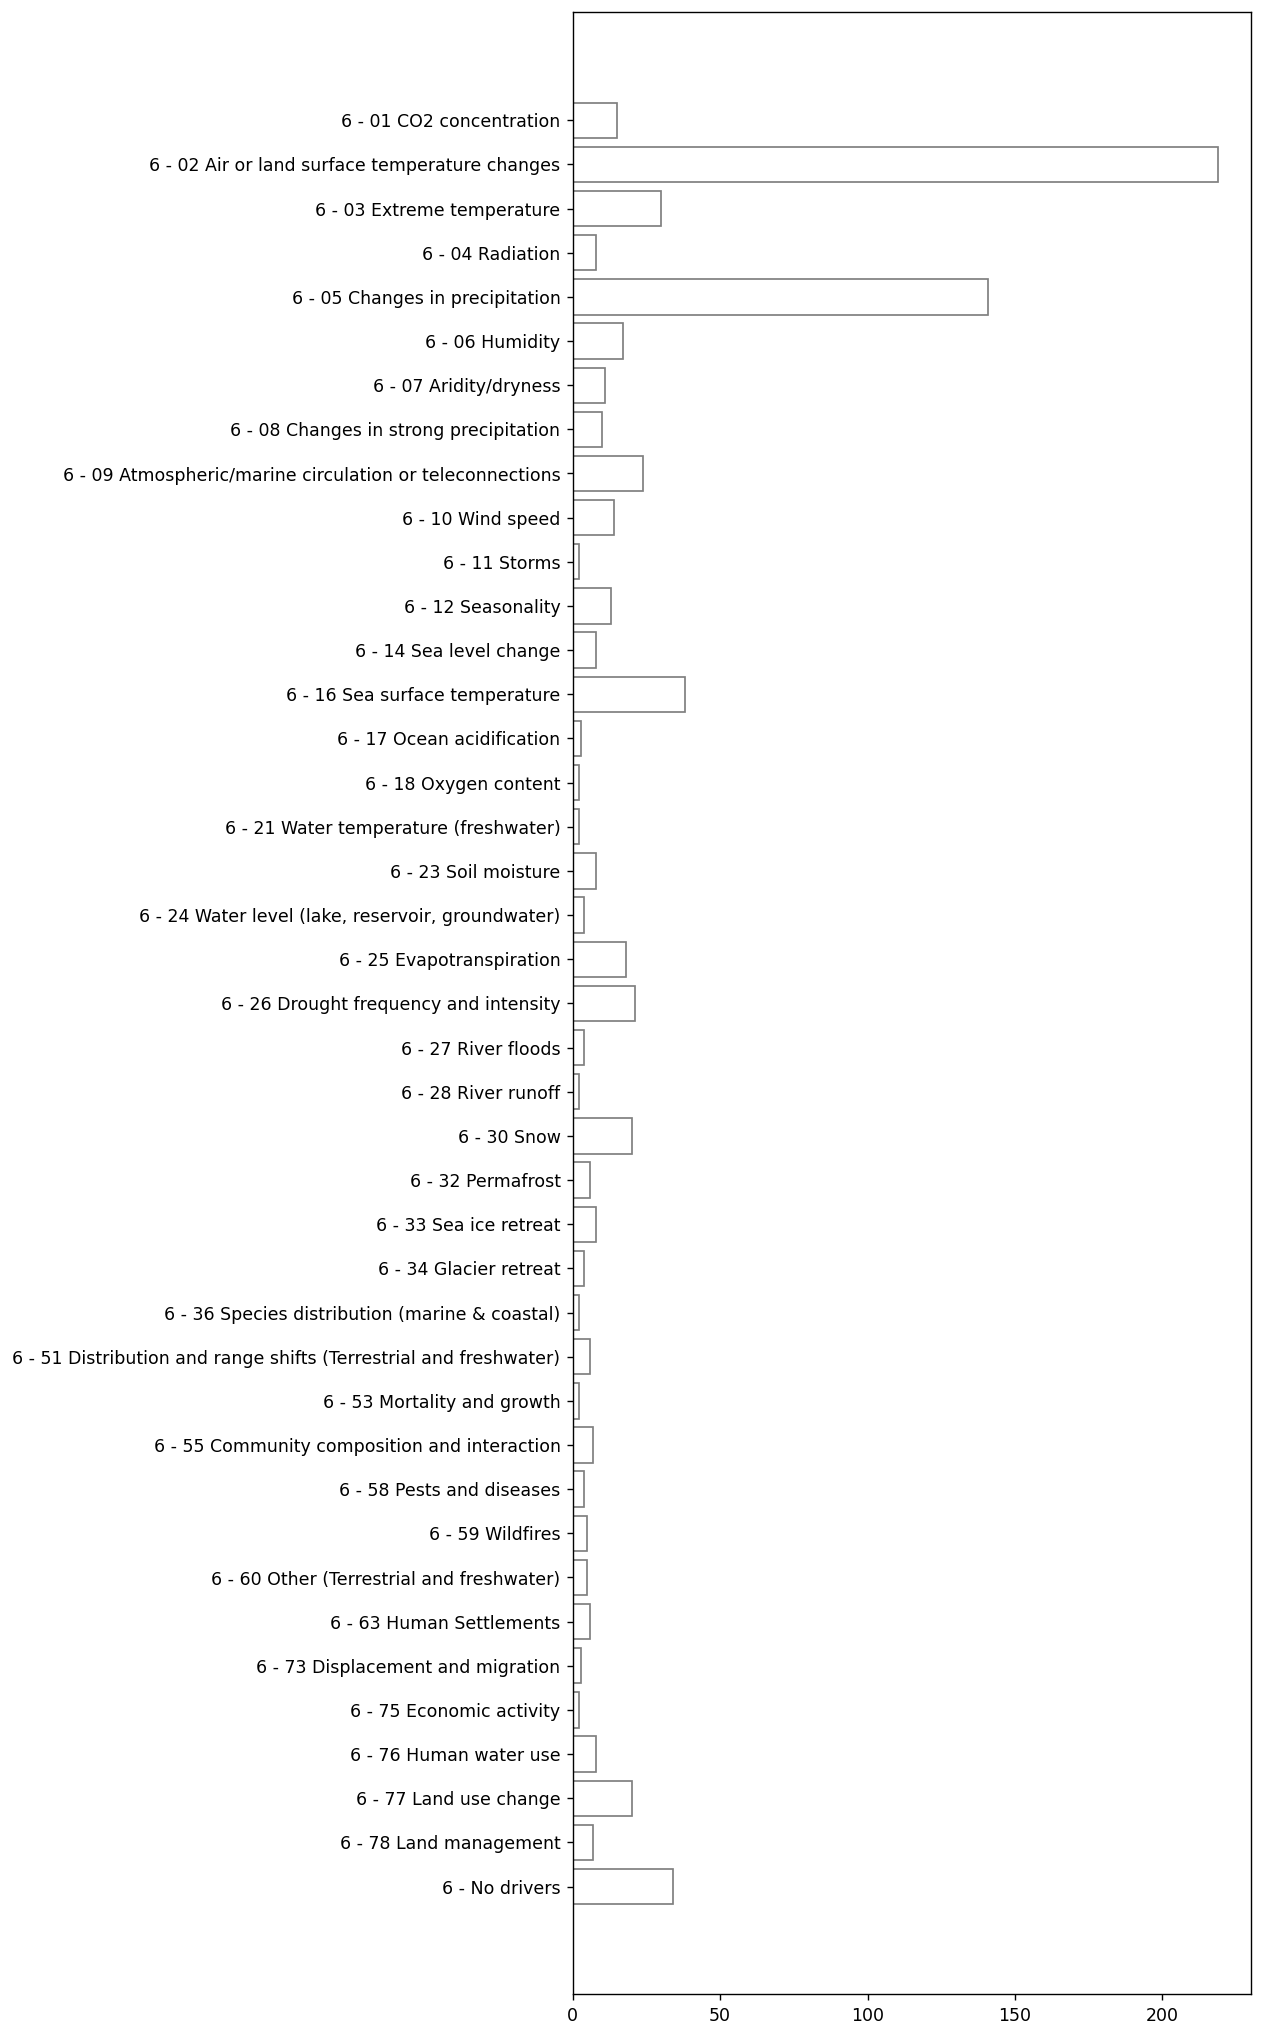

In [9]:


drivers = []
driver_dict = []
fig, ax = plt.subplots(dpi=125, figsize=(7,21))
i = 0
for c in df.columns:
    if "prediction" in c:
        continue
    if re.match("^6 - " ,c):
        im = c.replace("6 - ","4 - ")
        n = df.loc[attr_index, c].sum()
        if im not in df.columns:
            di = 0
            p_d = n
        else:
            di = df.loc[df[im]==1,c].sum()
            p_d = df.loc[df[im]==0,c].sum()
        if n < 2:
            continue
        driver_dict.append({"driver": c, "n":n, "intermediate_driver": di, "primary_driver":p_d})
        ax.barh(i,n,color="None",edgecolor="grey")
        i+=1
        
plt.gca().invert_yaxis()

driver_df = pd.DataFrame.from_dict(driver_dict)

ax.set_yticks(driver_df.index)
ax.set_yticklabels(driver_df['driver'])

all_drivers = list(driver_df['driver'])

driver_df.head()

In [10]:
## New summary cats
df['6 - Precipitation'] = 0
df.loc[(df['6 - 05 Changes in precipitation']==1) | (df['6 - 08 Changes in strong precipitation']==1),"6 - Precipitation"] = 1

df['Human drivers'] = 0
df.loc[
    (df['6 - 76 Human water use']==1) |
    (df['6 - 77 Land use change']==1),
    '6 - Human drivers' 
] = 1
 
df.loc[
    (df['6 - 03 Extreme temperature']==1) & 
    (df['6 - 16 Sea surface temperature']==0) & 
    (df['6 - 21 Water temperature (freshwater)']==0),
    '6 - 02 Air or land surface temperature changes'
] = 1

df['6 - Temperature'] = 0
df.loc[
    (df['6 - 03 Extreme temperature']==1) | 
    (df['6 - 16 Sea surface temperature']==1) | 
    (df['6 - 02 Air or land surface temperature changes']==1) |
    (df['6 - 21 Water temperature (freshwater)']==1),
    '6 - Temperature'
] = 1

df['6 - Water availability'] = 0
df.loc[
    (df['6 - 26 Drought frequency and intensity']==1) |
    (df['6 - 07 Aridity/dryness']==1) |
    (df['6 - 28 River runoff']==1),
    '6 - Water availability'
] = 1

#df['6 - ']

driver_selection = [
    #'6 - 01 CO2 concentration',
    #'6 - 02 Air or land surface temperature changes',
    '6 - Temperature',
    '6 - Precipitation',
    #'6 - 16 Sea surface temperature',
    #'6 - 09 Atmospheric/marine circulation or teleconnections',
    #'6 - 10 Wind speed','6 - 11 Storms','6 - 14 Sea level change',#'6 - 26 Drought frequency and intensity',
    #'6 - 04 Radiation',
    #'6 - 33 Sea ice retreat',
    #'6 - No drivers', 
    '6 - 30 Snow', 
    '6 - Human drivers', 
    #'6 - 12 Seasonality',
    '6 - Water availability',
]

df["6 - None/Other"] = 0
df.loc[(df.index.isin(attr_index)) & (df.loc[:,driver_selection].sum(axis=1)==0),"6 - None/Other"] = 1

all_docs = df.loc[physical_index.intersection(attr_index),].reset_index(drop=True)
print(all_docs.shape[0])

covered = all_docs[all_docs[driver_selection].sum(axis=1)>0]
uncovered = all_docs[all_docs[driver_selection].sum(axis=1)==0]

print(f"{covered.shape[0]/all_docs.shape[0]:.1%}")



386
81.3%


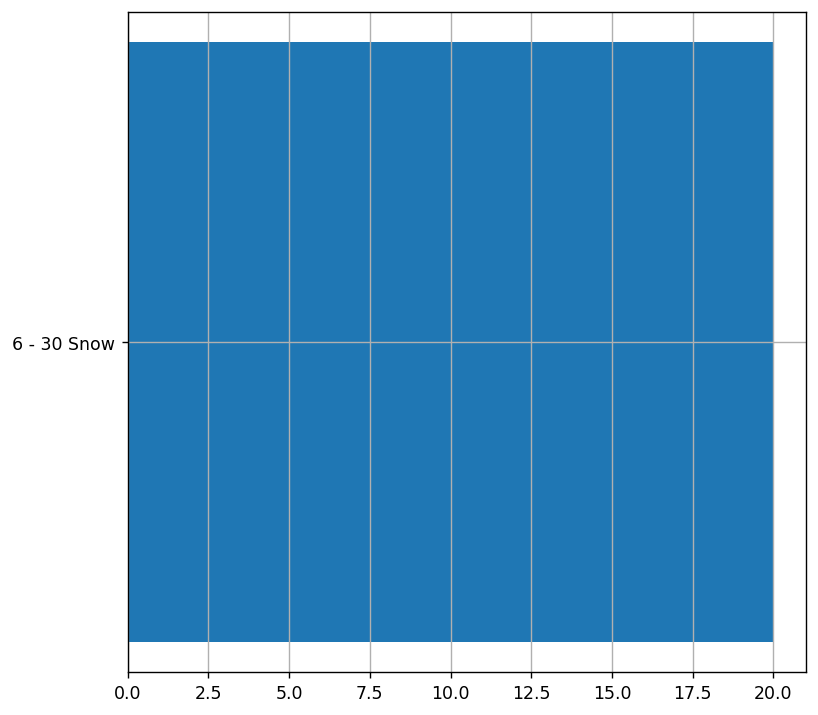

In [11]:
fig, ax = plt.subplots(dpi=125, figsize=(7,7))



add_none = False
if add_none:
    driver_selection.append("6 - None/Other")
    c = "6 - None/Other"
    if c not in driver_df['driver']:
        im = c.replace("6 - ","4 - ")
        n = df.loc[attr_index, c].sum()
        if im not in df.columns:
            di = 0
            p_d = n
        else:
            di = df.loc[df[im]==1,c].sum()
            p_d = df.loc[df[im]==0,c].sum()
        driver_dict.append({"driver": c, "n":n, "intermediate_driver": di, "primary_driver":p_d})
        driver_df = pd.DataFrame.from_dict(driver_dict)

pdf = driver_df.loc[driver_df['driver'].isin(driver_selection),].query('n<300').sort_values('n').reset_index(drop=True)
ax.barh(pdf.index, pdf['n'])


ax.set_yticks(pdf.index)
ax.set_yticklabels(pdf['driver'])

ax.grid()

plt.show()


In [12]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

import scoping.utils

from importlib import reload  
reload(scoping.utils.learning_utils)


classes = driver_selection
print(driver_selection)
y = np.matrix(df[classes].fillna(0))
print(y.shape)

multimodels = [
    #{
    #    'title': 'One vs rest SVC', 
    #    'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    #},
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_drivers, metrics, df = lu.cross_validate_models(
    X, y, multimodels, attr_index, 
    n_splits=6, classes=classes, df = df, roundup=False, upsample=True
)

['6 - Temperature', '6 - Precipitation', '6 - 30 Snow', '6 - Human drivers', '6 - Water availability']
(84825, 5)
1


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv

2


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv

6


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


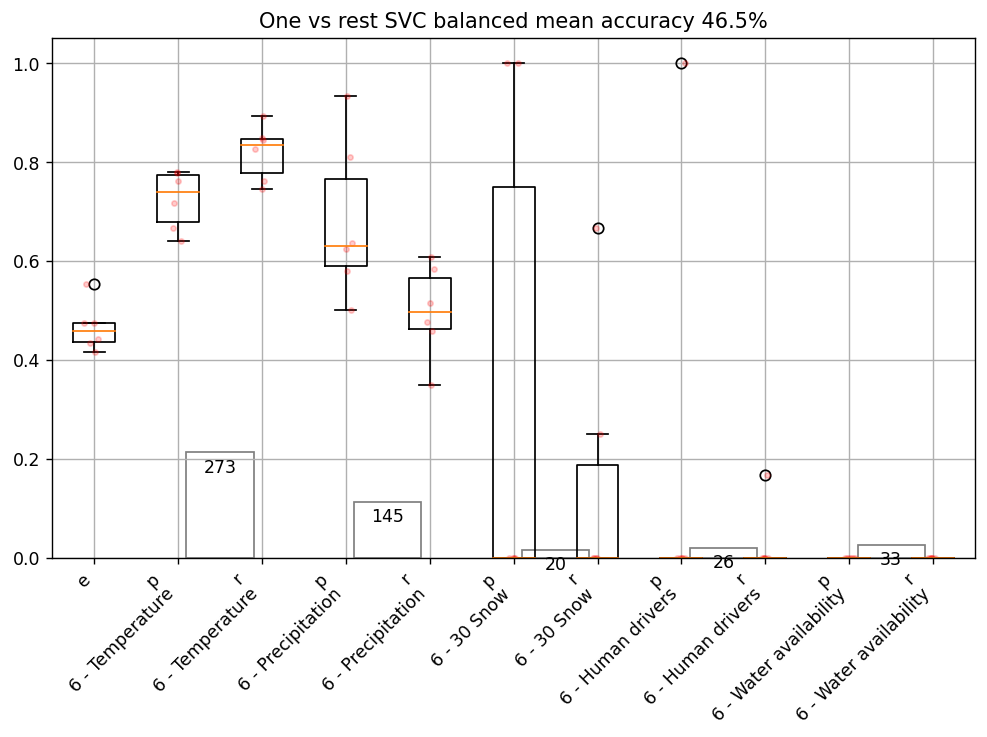

In [13]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(multimodels_drivers, metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[attr_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[attr_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.savefig("../plots/prediction_models/drivers.pdf")
plt.show()

In [14]:
matrix_clusterer

NameError: name 'matrix_clusterer' is not defined

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.ensemble import MajorityVotingClassifier
from skmultilearn.cluster import MatrixLabelSpaceClusterer
from sklearn.cluster import KMeans
from skmultilearn.cluster import MatrixLabelSpaceClusterer
from sklearn.cluster import KMeans
from skmultilearn.problem_transform import ClassifierChain


import scoping.utils

from importlib import reload  
reload(scoping.utils.learning_utils)


classes = driver_selection
print(driver_selection)
y = np.matrix(df[classes].fillna(0))
print(y.shape)

matrix_clusterer = MatrixLabelSpaceClusterer(clusterer=KMeans(n_clusters=2))
matrix_clusterer.fit_predict(X[attr_index],y[attr_index])

multimodels = [
    #{
    #    'title': 'One vs rest SVC', 
    #    'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    #},
    #{
    #    'title': 'One vs rest SVC balanced', 
    #    'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    #},
    {
        'title': 'MajorityVoting', 
        'model': MajorityVotingClassifier(
            clusterer = matrix_clusterer,
            classifier = ClassifierChain(classifier=SVC(kernel='linear', class_weight="balanced", probability=True)),
            require_dense=[False, True]
        )
    },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_drivers, metrics, df = lu.cross_validate_models(
    X, y, multimodels, attr_index, 
    n_splits=6, classes=classes, df = df, roundup=False, #upsample=True
)

In [ ]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(multimodels_drivers, metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[attr_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[attr_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

In [ ]:
django.db.connection.close()
c = "12 - Coastal and marine Ecosystems"
#c = "12 - Mountains, snow and ice"
c = "6 - Human drivers"
c = "6 - Water availability"
fp = df.loc[attr_index,].loc[(df[c]==1) & (df[f'{c} - k_prediction']<0.5)]
#fp = df.loc[attr_index,].loc[(df[c]==0) & (df[f'{c} - k_prediction_binary']>0.5)]
#fp = df.loc[attr_index,].loc[(df[c]==1) & (df[f'{c} - k_prediction_binary']>0.5)]
print(fp.shape)
for i, row in fp.sort_values(f'{c} - k_prediction',ascending=False).head(5).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print(row['title'])
    print(row['content'])
    print(d.id)
    print("impacts:")
    print(d.docusercat_set.filter(category__level=4).values('category__name','user__username'))
    print("drivers:")
    print(d.docusercat_set.filter(category__level=6).values('category__name','user__username'))
    for col in df.columns:
        if "k_prediction" in col:
            print(col)
            print(row[col])

In [ ]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)
classes = driver_selection

cols = [f"{c} - k_prediction_binary" for c in classes]

y_pred = np.zeros((y[physical_index].shape[0],y[physical_index].shape[1]+1))
y_pred[:,:-1] = np.array(list(df.loc[list(physical_index),cols].values))
y_pred[:,len(classes)] = np.where(y_pred.sum(axis=1)==0,1,0)
   
y_true = np.zeros((y[physical_index].shape[0],y[physical_index].shape[1]+1))
y_true[:,:-1] = y[physical_index]
y_true[:,len(classes)] = np.where(y_true.sum(axis=1)==0,1,0)


confusion_matrix = np.zeros(shape=(len(cols)+1,len(cols)+1),dtype=float)

classes = classes+["None"]

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(physical_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n
        
    #sums_pred = y_pred.sum(axis=1).ravel()
    #confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    #sums_true = y_true.sum(axis=1).ravel()
    #confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    #confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]


def plot_confusion_matrix(cm, all_classes, norm=None, broad_cats = [], ls=False):
    cm = np.copy(cm)
    if norm is not None:
        cm = cm/cm.sum(axis=norm,keepdims=True)
    cm[cm == 0] = np.nan

    mat = ax.imshow(cm, cmap="Blues",vmin=0,origin="lower")
    ax.set_xticks(np.arange(-.5, cm.shape[0], 1), minor=True);
    ax.set_yticks(np.arange(-.5, cm.shape[0], 1), minor=True);

    ax.grid(which="minor",color='grey', linestyle='-', linewidth=0.2)

    if ls:
        for j, c in enumerate(all_classes):
            for k, c in enumerate(all_classes):
                n  = cm[k,j]
                if pd.isna(n):
                    n = 0
                if n > cm.max()/2:
                    color="#d9d9d9"
                else:
                    color="#525252"
                if norm is not None:
                    ax.text(j,k, f"{n:.0%}",ha="center",color=color)
                else:
                    ax.text(j,k, f"{n}",ha="center",color=color)
                
            #if j < len(all_classes)+21:    
            #    ax.text(j,len(all_classes)-0.25,f"{y_true[:,j].sum():,.0f}",ha="center",va="center",color="#525252")
            #    ax.text(len(all_classes)-0.25, j, f"{y_pred[:,j].sum():,.0f}",ha="center",va="center", color="#525252")

    ax.set_xticks(list(range(len(all_classes))))
    ax.set_xticklabels([x.replace("4 - ","") for x in all_classes],rotation=45,ha="right",fontsize=5)

    ax.set_yticks(list(range(len(all_classes))))
    ax.set_yticklabels([x.replace("4 - ","") for x in all_classes],ha="right",fontsize=5)
    ax.set_xlabel("True value", fontsize=6)
    ax.set_ylabel("Predicted value", fontsize=6)


    cbar = fig.colorbar(mat, ax=ax, pad=0.2)
    cbar.ax.tick_params(labelsize=6)
    if norm ==0:
        cbar.set_label("% of True values")
    
    for bc in broad_cats:
        rect = patches.Rectangle((bc['start']-0.5,bc['start']-0.5),bc['size'],bc['size'],fill=False)
        ax.add_patch(rect)
    

plot_confusion_matrix(confusion_matrix, classes, norm=None, ls=True)   
#plot_confusion_matrix(confusion_matrix,classes, norm=1)

In [30]:
driver_selection = [
    #'6 - 01 CO2 concentration',
    '6 - Temperature',
    '6 - Precipitation',#'6 - 16 Sea surface temperature',
    #'6 - 09 Atmospheric/marine circulation or teleconnections',
    #'6 - 10 Wind speed','6 - 11 Storms','6 - 14 Sea level change',#'6 - 26 Drought frequency and intensity',
    #'6 - 04 Radiation',
    #'6 - 33 Sea ice retreat',
    #'6 - No drivers', '6 - 30 Snow', '6 - Human drivers', 
    #'6 - 12 Seasonality',
    #'6 - Water availability',
]

classes = driver_selection

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

import scoping.utils

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    #{
    #    'title': 'One vs rest SVC', 
    #    'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    #},
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_drivers_few, metrics, df = lu.cross_validate_models(
    X, y, multimodels, physical_index, n_splits=6, classes=classes, df = df,
    upsample=False
)

(84825, 2)
1
2
3
4
5
6


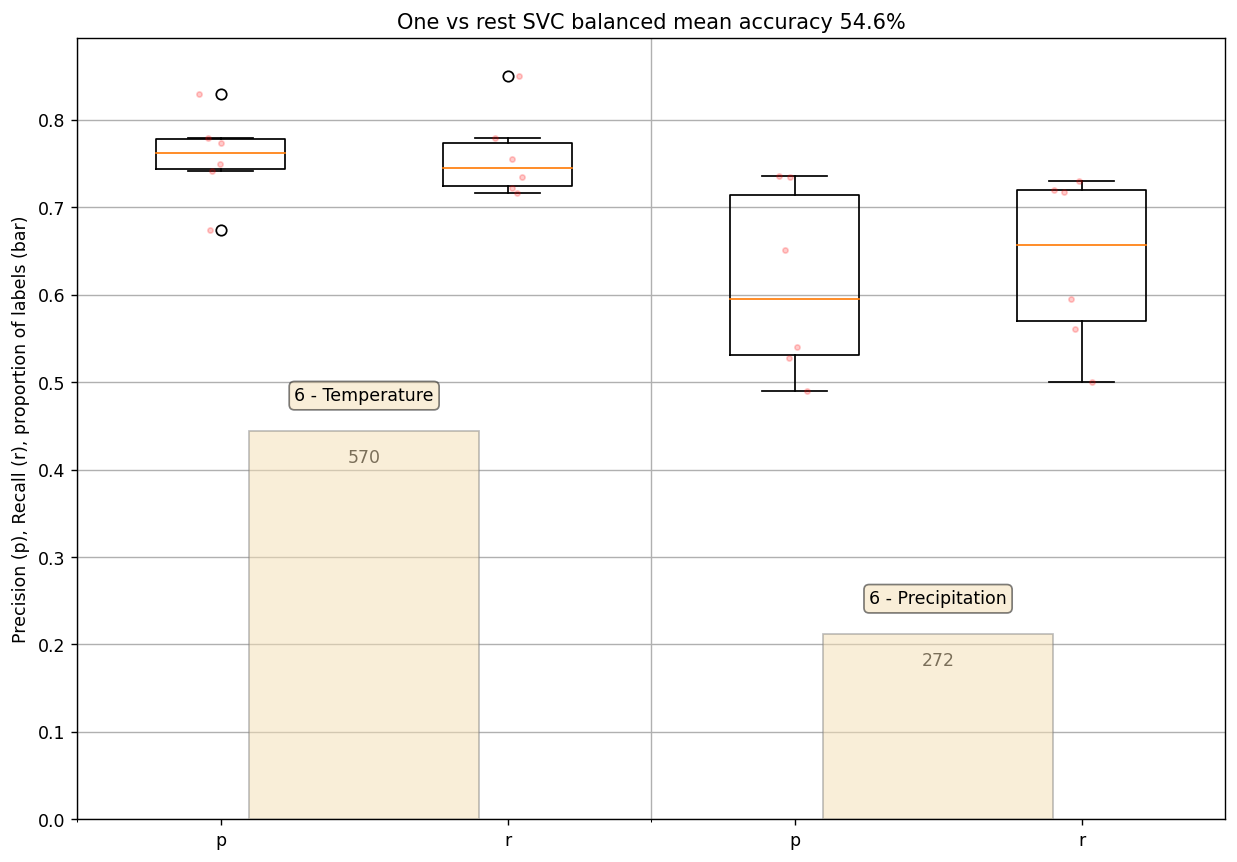

In [31]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(10,7),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
    
pmetrics = [m for m in metrics if m!="e"]
lu.plot_model_output(multimodels_drivers_few, pmetrics , fig, axs)
ax = axs[0]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df[c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+.5,s-0.03,int(df[c].sum()),ha="center",va="center")
            ax.text(i+.5,max([.22,s+0.03]), c.replace('12 - ','').replace('and','\nand'),va="bottom",ha="center",bbox=props)
            ax.bar(i+.5,s,color="wheat",edgecolor="grey",alpha=0.5,zorder=5)
        
ax.set_xticklabels([x.split('\n')[0] for x in pmetrics],rotation=0,ha="center")
ax.grid(False,axis="x")
ax.grid(True,which="minor",axis="x")
ax.set_xticks([i+.5 for i,x in enumerate(pmetrics) if i%2==0],minor=True)
ax.set_ylabel('Precision (p), Recall (r), proportion of labels (bar)')
fig.tight_layout()
plt.savefig('../plots/prediction_models/drivers_tp.pdf',bbox_inches="tight")
plt.show()

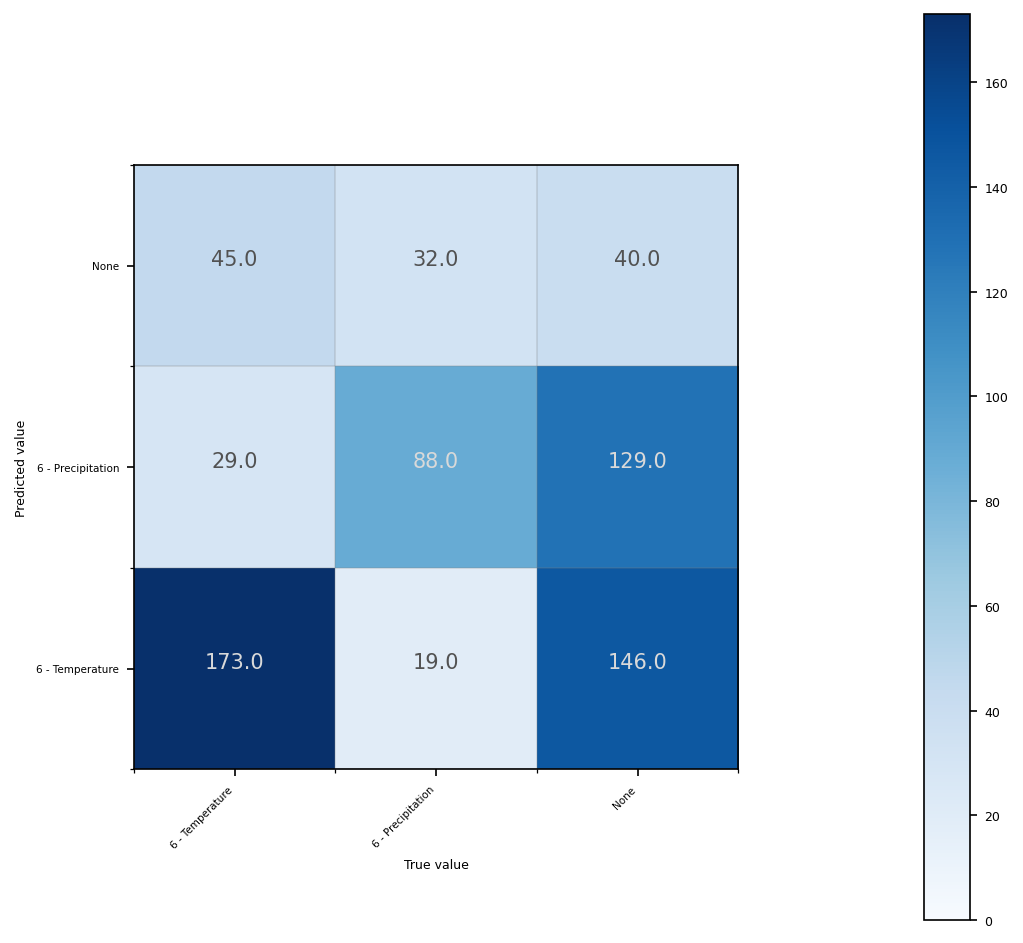

In [44]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)

classes = driver_selection

cols = [f"{c} - k_prediction_binary" for c in classes]
y_pred = np.array(list(df.loc[list(physical_index.intersection(attr_index)),cols].values))
   
y_true = y[physical_index.intersection(attr_index)]

confusion_matrix = np.zeros(shape=(len(cols)+1,len(cols)+1),dtype=float)

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(physical_index.intersection(attr_index))):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n
        
    sums_pred = y_pred.sum(axis=1).ravel()
    confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    sums_true = y_true.sum(axis=1).ravel()
    confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]

        
plot_confusion_matrix(confusion_matrix,classes + ["None"], norm=None, ls=True)

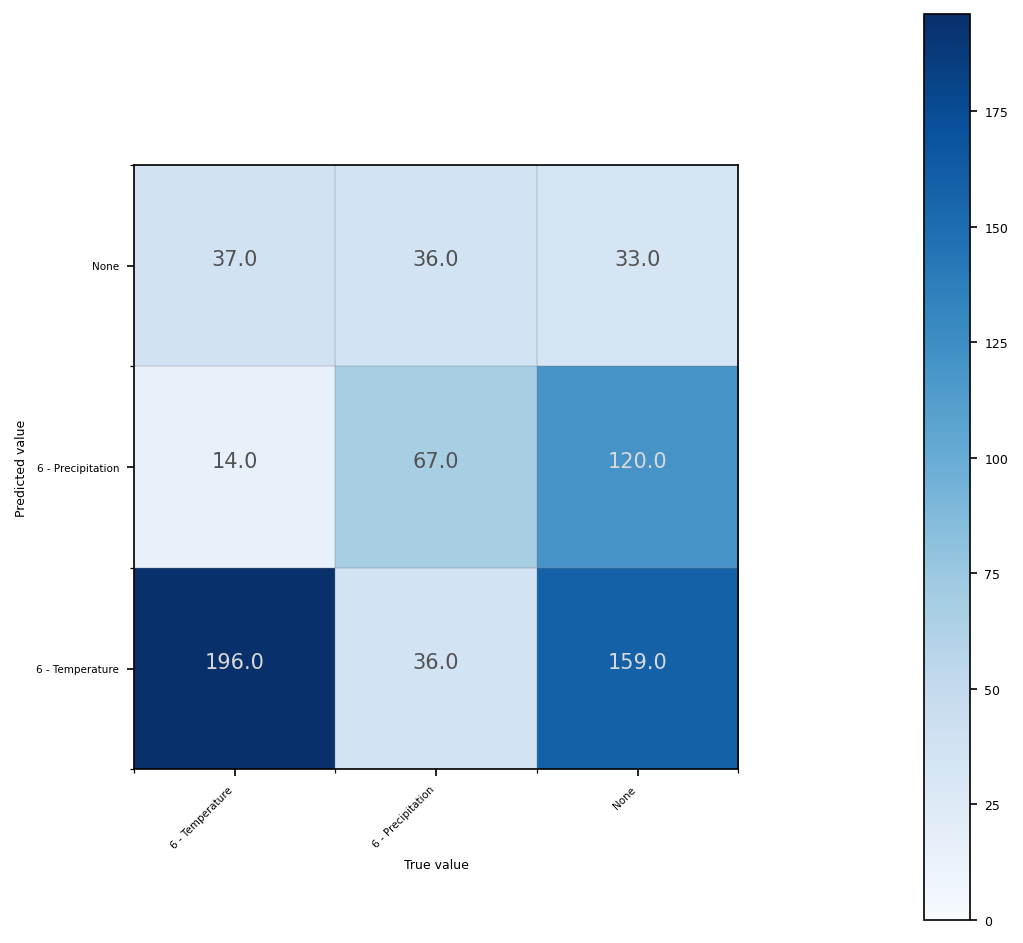

In [39]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)

classes = driver_selection

cols = [f"{c} - k_prediction_binary" for c in classes]
y_pred = np.array(list(df.loc[list(physical_index.intersection(attr_index)),cols].values))
   
y_true = y[physical_index.intersection(attr_index)]

confusion_matrix = np.zeros(shape=(len(cols)+1,len(cols)+1),dtype=float)

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(physical_index.intersection(attr_index))):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n
        
    sums_pred = y_pred.sum(axis=1).ravel()
    confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    sums_true = y_true.sum(axis=1).ravel()
    confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]

        
plot_confusion_matrix(confusion_matrix,classes + ["None"], norm=None, ls=True)

In [24]:
unseen_index = df.loc[df["2 - Trend or climate change attribtion - lower_pred"]>0.5,].index.difference(attr_index)
unseen_index

Int64Index([    1,     3,     7,     8,    12,    20,    28,    40,    46,
               49,
            ...
            84798, 84799, 84802, 84805, 84809, 84811, 84812, 84814, 84815,
            84816],
           dtype='int64', length=23350)

In [25]:


y = np.matrix(df[classes])
kf = KFold(n_splits=6)
kfs = kf.split(X[attr_index],y[attr_index])
y_preds = []
i = 0
for k_train, k_test in kfs:
    i+=1
    print(i)
    clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    k_train = physical_index[k_train]
    clf.fit(X[k_train],y[k_train])
    y_preds.append(clf.predict(X[unseen_index]))

1
2
3
4
5
6


In [26]:
i = 0
np.array(y_preds)[:,:,i].shape

for i, c in enumerate(classes):
    mean_pred = np.mean(np.array(y_preds)[:,:,i], axis=0)
    std_pred = np.std(np.array(y_preds)[:,:,i], axis=0)
    preds_upper = np.minimum(mean_pred + std_pred, 1)
    preds_lower = np.maximum(mean_pred - std_pred, 0)


    df.loc[unseen_index,f'{c} - mean_prediction'] = mean_pred
    df.loc[unseen_index,f'{c} - std_prediction'] = std_pred
    df.loc[unseen_index,f'{c} - lower_pred'] = preds_lower
    df.loc[unseen_index,f'{c} - upper_pred'] = preds_upper

In [27]:
df.to_csv('../data/category_predictions.csv', index=False)

In [41]:
qid = 8272
revectorize = True
retransform = False
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5, max_df=0.8, strip_accents='unicode', 
        max_features=10000,
        tokenizer=snowball_stemmer(),
        sublinear_tf=True
    )
    vec.fit(df.loc[physical_index,'content'].astype("str") + " " + df.loc[physical_index,'title'] + df.loc[physical_index,"wosarticle__de"])

    X = vec.transform(df['content'].astype("str")+" " + df['title'].astype("str") + df['wosarticle__de'].astype("str"))    
    with open (f'../data/vec_{qid}_prel.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{qid}_prel.npz', X)
else:
    with open (f'../data/vec_{qid}_prel.pickle','rb') as f:
        vec = pickle.load(f)
        if retransform:
            X = vec.transform(df['content'].astype("str"))
            scipy.sparse.save_npz(f'../data/X_{qid}_prel.npz', X)
        else:
            X = scipy.sparse.load_npz(f'../data/X_{qid}_prel.npz')
            
            
print(df.shape)
print(X.shape)

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(84825, 318)
(84825, 3040)


In [42]:
driver_selection = [
    #'6 - 01 CO2 concentration',
    '6 - Temperature',
    '6 - Precipitation',#'6 - 16 Sea surface temperature',
    #'6 - 09 Atmospheric/marine circulation or teleconnections',
    #'6 - 10 Wind speed','6 - 11 Storms','6 - 14 Sea level change',#'6 - 26 Drought frequency and intensity',
    #'6 - 04 Radiation',
    #'6 - 33 Sea ice retreat',
    #'6 - No drivers', '6 - 30 Snow', '6 - Human drivers', 
    #'6 - 12 Seasonality',
    #'6 - Water availability',
]

classes = driver_selection

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

import scoping.utils

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    #{
    #    'title': 'One vs rest SVC', 
    #    'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    #},
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_drivers_few, metrics, df = lu.cross_validate_models(
    X, y, multimodels, physical_index, n_splits=6, classes=classes, df = df,
    upsample=False
)

(84825, 2)
1
2
3
4
5
6


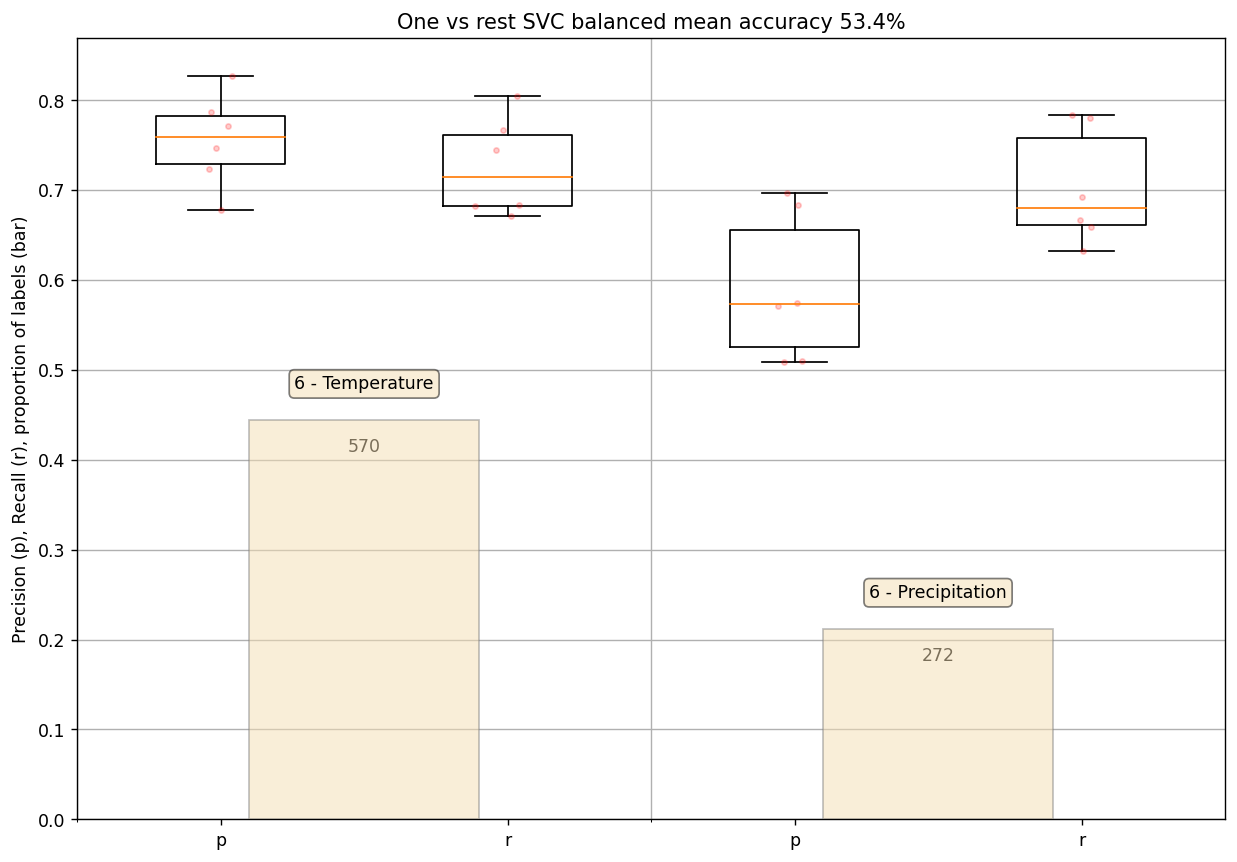

In [43]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(10,7),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
    
pmetrics = [m for m in metrics if m!="e"]
lu.plot_model_output(multimodels_drivers_few, pmetrics , fig, axs)
ax = axs[0]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df[c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+.5,s-0.03,int(df[c].sum()),ha="center",va="center")
            ax.text(i+.5,max([.22,s+0.03]), c.replace('12 - ','').replace('and','\nand'),va="bottom",ha="center",bbox=props)
            ax.bar(i+.5,s,color="wheat",edgecolor="grey",alpha=0.5,zorder=5)
        
ax.set_xticklabels([x.split('\n')[0] for x in pmetrics],rotation=0,ha="center")
ax.grid(False,axis="x")
ax.grid(True,which="minor",axis="x")
ax.set_xticks([i+.5 for i,x in enumerate(pmetrics) if i%2==0],minor=True)
ax.set_ylabel('Precision (p), Recall (r), proportion of labels (bar)')
fig.tight_layout()
#plt.savefig('../plots/prediction_models/drivers_tp.pdf',bbox_inches="tight")
plt.show()